In [ ]:
# ===== Cell 1: installs (Colab) =====
!pip -q install statsmodels scikit-learn xgboost python-pptx
# set True to also try N-BEATS (heavy install)
INCLUDE_NBEATS = True
if INCLUDE_NBEATS:
    !pip -q install "darts[u]" torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.8/344.8 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# ===== Cell 2: imports, config, utilities =====
import os, glob, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# PowerPoint
from pptx import Presentation
from pptx.util import Inches, Pt

# --------------------
# CONFIG (edit as needed)
# --------------------
FILE_PATH_CANDIDATES = [
    "PriceHist 1.xlsx",
    "PriceHist 1-2.xlsx",
]
SHEET = "Prices"
DATE_YEAR_COL = "Years (Date)"
DATE_MONTH_COL = "Months (Date)"
COL_PREFIX = "Average of "

SEASONAL_PERIOD = 12
TEST_HORIZON = 12
FORECAST_HORIZON = 6
ROLLING_MA = 7
LAGS = [1, 2, 3, 6, 12]
LOG_TRANSFORM = True  # for SARIMA only

SAVE_DIR = "figs"
PPTX_PATH = "Forecast_Charts_and_Table.pptx"
RESULTS_XLSX = "consolidated_results.xlsx"

os.makedirs(SAVE_DIR, exist_ok=True)

# --------------------
# helpers
# --------------------
def safe_mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    if y_true.size == 0:
        return np.nan
    eps = 1e-8
    return float(np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100)

def seasonal_naive(series, horizon, m=12):
    s = series.values
    if len(s) >= m:
        tmpl = s[-m:]
        return np.tile(tmpl, int(np.ceil(horizon/m)))[:horizon]
    return np.repeat(s[-1], horizon)

def is_explosive(fc_vals, history, window=24, factor=3.0):
    hist = history.dropna()
    if hist.empty:
        return False
    tail = hist.iloc[-min(window, len(hist)):]
    hi = np.nanmax(tail.values)
    fc_vals = np.asarray(fc_vals, dtype=float)
    if not np.all(np.isfinite(fc_vals)):
        return True
    return np.nanmax(fc_vals) > factor * hi

def sarimax_auto(series, seasonal_period=12):
    y = series.astype(float)
    pdq = [(p,d,q) for p in (0,1,2) for d in (0,1) for q in (0,1,2)]
    PDQ = [(P,D,Q,seasonal_period) for P in (0,1) for D in (0,1) for Q in (0,1)]
    best = {"aic": np.inf, "order": None, "sorder": None}
    for order in pdq:
        for sorder in PDQ:
            try:
                res = SARIMAX(
                    y, order=order, seasonal_order=sorder,
                    enforce_stationarity=True, enforce_invertibility=True
                ).fit(disp=False)
                if res.aic < best["aic"]:
                    best = {"aic": res.aic, "order": order, "sorder": sorder}
            except Exception:
                continue
    return best["order"], best["sorder"]

def make_features(series, lags=LAGS):
    df_feat = pd.DataFrame({"y": series})
    for lag in lags:
        df_feat[f"lag_{lag}"] = series.shift(lag)
    df_feat["month"] = series.index.month
    df_feat["year"]  = series.index.year
    return df_feat.dropna()

def quarterly_bands(ax, idx):
    if len(idx) == 0: return
    q = 0
    start = idx[0]
    for i in range(len(idx)):
        if (idx[i].month - 1) % 3 == 0 and i != 0:
            color = "#e8f5e9" if q % 2 == 0 else "#ffebee"
            ax.axvspan(start, idx[i], color=color, alpha=0.35, linewidth=0)
            start = idx[i]; q += 1
    ax.axvspan(start, idx[-1], color=("#e8f5e9" if q % 2 == 0 else "#ffebee"), alpha=0.35, linewidth=0)

def plot_dual(material, model_name, mape_val, series, test, test_fc, future_fc,
              rolling_ma=7, save_path=None):
    """Left: full history + eval + future. Right: last 24 months + future."""
    future_idx = pd.date_range(series.index[-1] + pd.offsets.MonthBegin(1),
                               periods=len(future_fc), freq="MS")

    fig, axes = plt.subplots(1, 2, figsize=(16, 4.5), sharey=True)

    # ----- Left: full history -----
    ax = axes[0]
    quarterly_bands(ax, series.index)
    ax.plot(series.index, series.values, color="k", lw=1.8, label="Historical Price")
    ax.plot(series.index, series.rolling(rolling_ma, min_periods=1).mean(),
            color="C0", lw=1.8, label=f"{rolling_ma}-Month MA")
    if len(test) > 0:
        ax.plot(test.index, test.values, color="C1", lw=2.5, label="Actual (Test)")
        ax.plot(test.index, test_fc, color="C1", lw=1.8, ls="--", label="Forecast (Eval)")
    ax.plot(future_idx, future_fc, color="C3", lw=1.8, ls="--", label=f"Future Forecast ({len(future_fc)} mo)")
    ax.set_title("Full history + forecast")
    ax.set_ylabel("Price per UOM")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")

    # ----- Right: last 24 months + future -----
    ax = axes[1]
    # window of last 24 months from series start to last point
    last_24_start = series.index.max() - pd.DateOffset(months=24)
    series_24 = series[series.index >= last_24_start]
    quarterly_bands(ax, series_24.index)
    ax.plot(series_24.index, series_24.values, color="k", lw=1.8, label="Historical Price")
    ax.plot(series_24.index, series_24.rolling(rolling_ma, min_periods=1).mean(),
            color="C0", lw=1.8, label=f"{rolling_ma}-Month MA")
    ax.plot(future_idx, future_fc, color="C3", lw=1.8, ls="--", label=f"Future Forecast ({len(future_fc)} mo)")
    ax.set_title(f"{series_24.index.year.min()}–{series.index.year.max()} + forecast")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")

    # robust y-limits to avoid huge spikes flattening
    y_hist = series.values
    lo, hi = np.nanpercentile(y_hist, [1, 99])
    span = hi - lo if np.isfinite(hi - lo) and (hi - lo) > 0 else np.nanmax(y_hist)
    pad = 0.2 * span if np.isfinite(span) and span > 0 else 1.0
    for ax in axes:
        ax.set_ylim(max(0, lo - pad), hi + pad if np.isfinite(hi) else None)

    fig.suptitle(f"{material} — {model_name} | MAPE: {mape_val:.2f}%", y=1.02, fontsize=13)
    plt.tight_layout()
    plt.show()

    if save_path is not None:
        fig.savefig(save_path, dpi=180, bbox_inches="tight")
        plt.close(fig)

def get_model(name):
    if name == "Linear Regression":
        return LinearRegression()
    if name == "Random Forest":
        return RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
    if name == "XGBoost":
        return xgb.XGBRegressor(
            n_estimators=600, learning_rate=0.05, max_depth=4,
            subsample=0.9, colsample_bytree=0.9,
            objective="reg:squarederror", random_state=42, n_jobs=-1
        )
    raise ValueError("Unknown model")

def add_table_slides(prs, df, title="Consolidated Results", cols=None, max_rows_per_slide=12):
    if cols is None:
        cols = df.columns.tolist()
    chunks = [df.iloc[i:i+max_rows_per_slide] for i in range(0, len(df), max_rows_per_slide)]
    for i, chunk in enumerate(chunks, 1):
        slide = prs.slides.add_slide(prs.slide_layouts[5])  # Title Only
        slide.shapes.title.text = f"{title} ({i}/{len(chunks)})"
        rows, cols_count = chunk.shape[0] + 1, len(cols)
        left, top, width, height = Inches(0.5), Inches(1.4), Inches(9), Inches(5)
        table = slide.shapes.add_table(rows, cols_count, left, top, width, height).table
        # headers
        for j, c in enumerate(cols):
            table.cell(0, j).text = str(c)
            table.cell(0, j).text_frame.paragraphs[0].font.bold = True
        # body
        for r, (_, row) in enumerate(chunk[cols].iterrows(), start=1):
            for j, c in enumerate(cols):
                table.cell(r, j).text = "" if pd.isna(row[c]) else str(row[c])

def find_input_file(candidates):
    for c in candidates:
        if os.path.exists(c):
            return c
    # search a close match
    hits = glob.glob("PriceHist*.xlsx")
    if hits:
        return hits[0]
    raise FileNotFoundError("Input Excel file not found. Update FILE_PATH_CANDIDATES.")


In [ ]:
# --- Patch 1: correct sheet name (with safe fallback) ---
FILE_PATH = find_input_file(FILE_PATH_CANDIDATES)
try:
    # Will raise if missing
    pd.ExcelFile(FILE_PATH).parse("Prices", nrows=1)
    SHEET = "Prices"
except Exception:
    # keep whatever was set earlier, or first available
    SHEET = pd.ExcelFile(FILE_PATH).sheet_names[0]
print("Using sheet:", SHEET)

# --- Patch 2: plotting that matches your reference exactly ---
def plot_dual(material, model_name, mape_val, series, test, test_fc, future_fc,
              rolling_ma=7, save_path=None):
    """
    Left: full history + actual model forecast.
    Right: last 24 months + forecast.
    Each panel has its own y-scale.
    Caption at bottom: Material — Model | MAPE.
    """
    import matplotlib.pyplot as plt

    future_idx = pd.date_range(series.index[-1] + pd.offsets.MonthBegin(1),
                               periods=len(future_fc), freq="MS")

    fig, axes = plt.subplots(1, 2, figsize=(16, 4.5), sharey=False)

    # ---------- Left: Full history ----------
    ax = axes[0]
    quarterly_bands(ax, series.index)
    ax.plot(series.index, series.values, color="#1f77b4", lw=2.0, marker="o", ms=3,
            label="Historical Price")                        # blue
    ax.plot(future_idx, future_fc, color="#d62728", lw=2.0, marker="o", ms=3,
            linestyle="-", label="Forecast (model)")         # red forecast
    ax.set_title("Full history + forecast")
    ax.set_ylabel("Price per UOM")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")

    # ---------- Right: Last 24 months ----------
    start_24 = (series.index.max() - pd.DateOffset(months=23)).replace(day=1)
    series_24 = series[series.index >= start_24]
    ax = axes[1]
    quarterly_bands(ax, series_24.index)
    ax.plot(series_24.index, series_24.values, color="#1f77b4", lw=2.0, marker="o", ms=3)
    ax.plot(future_idx, future_fc, color="#d62728", lw=2.0, marker="o", ms=3, linestyle="-")
    ax.set_title(f"{series_24.index.min().year}–{series.index.max().year} + forecast")
    ax.grid(True, alpha=0.3)

    # Caption
    fig.text(0.5, -0.02, f"{material} — {model_name}    |    MAPE: {mape_val:.2f}%",
             ha="center", va="top", fontsize=13)

    plt.tight_layout()
    plt.show()

    if save_path:
        fig.savefig(save_path, dpi=180, bbox_inches="tight")
        plt.close(fig)





Using sheet: Prices


Materials detected: Glycerine, Acetic acid, Glycerine Crude, n-Butanol, Acetone, Phenol, Benzene, Propylene, Methanol


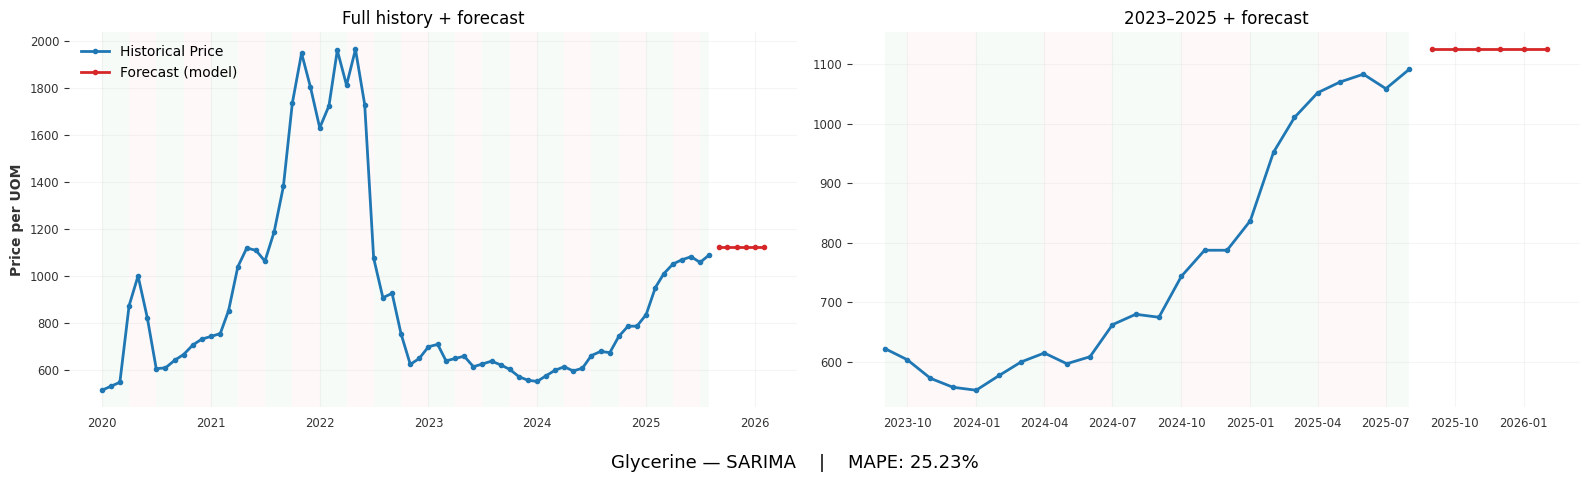

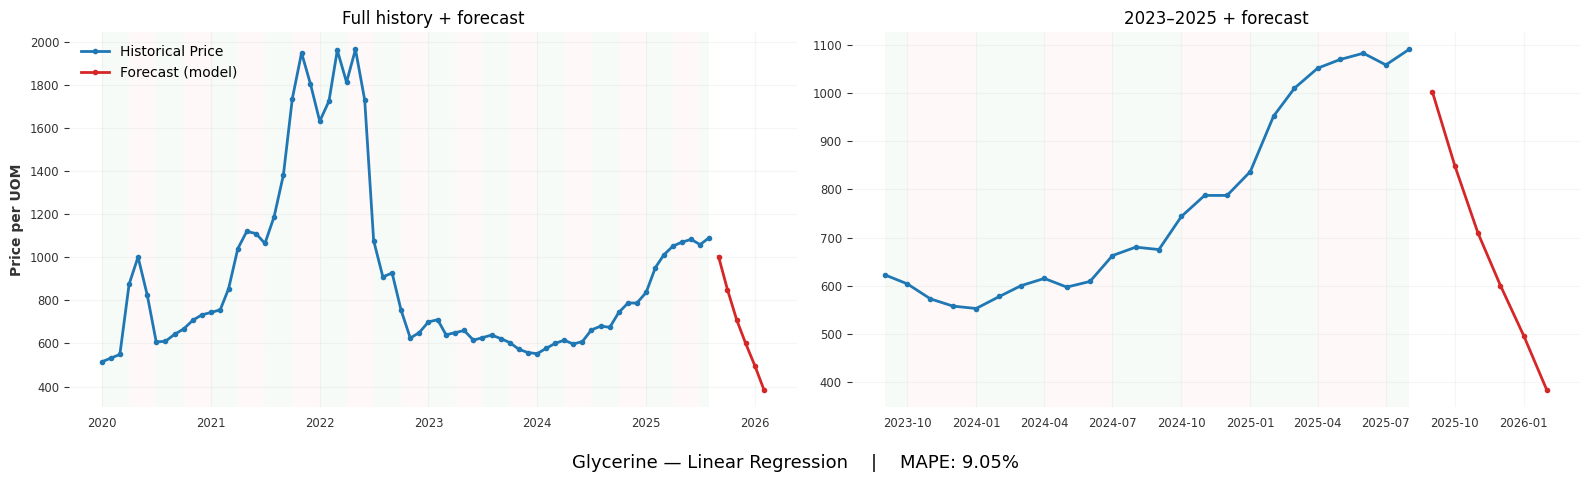

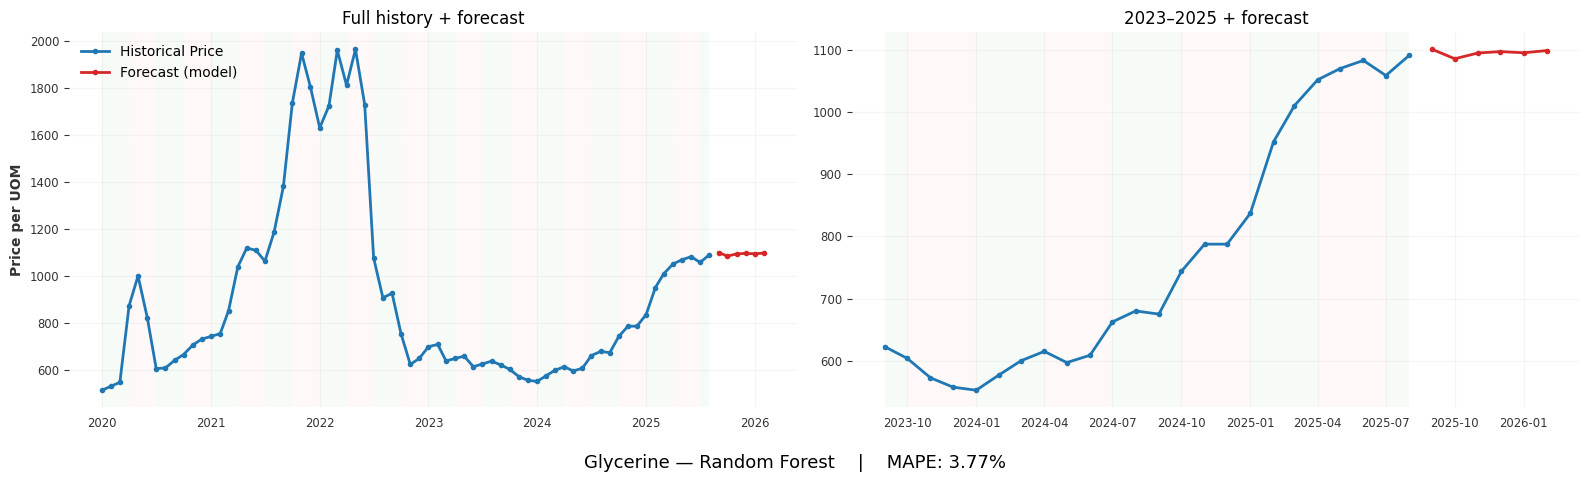

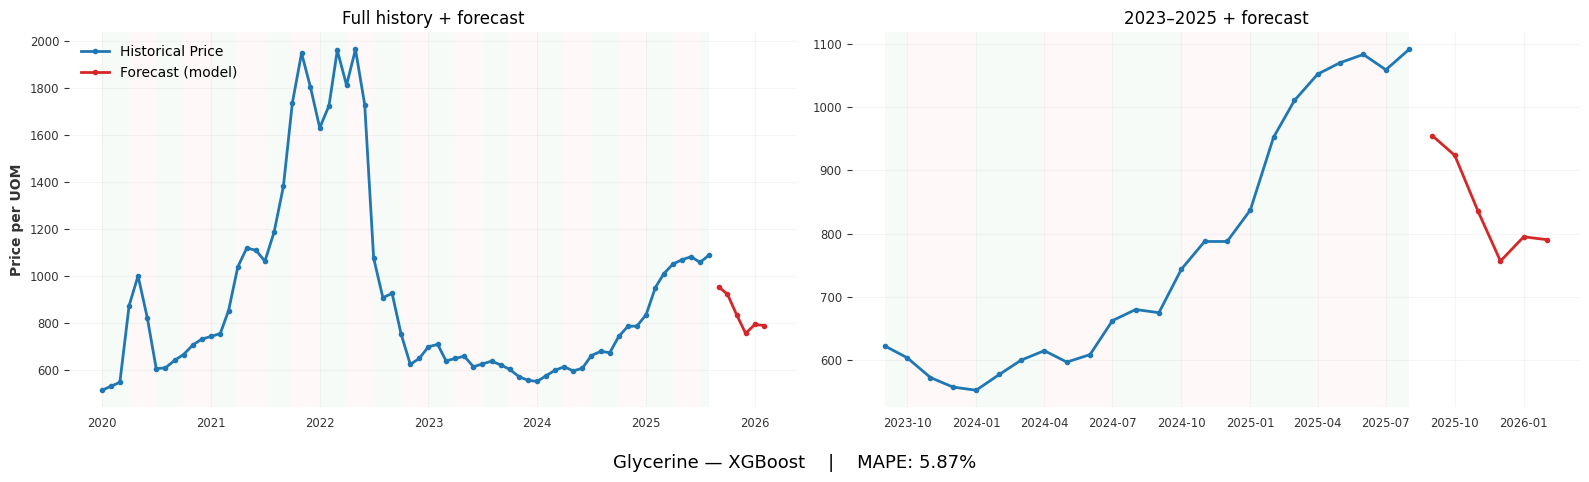

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.599    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.594    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

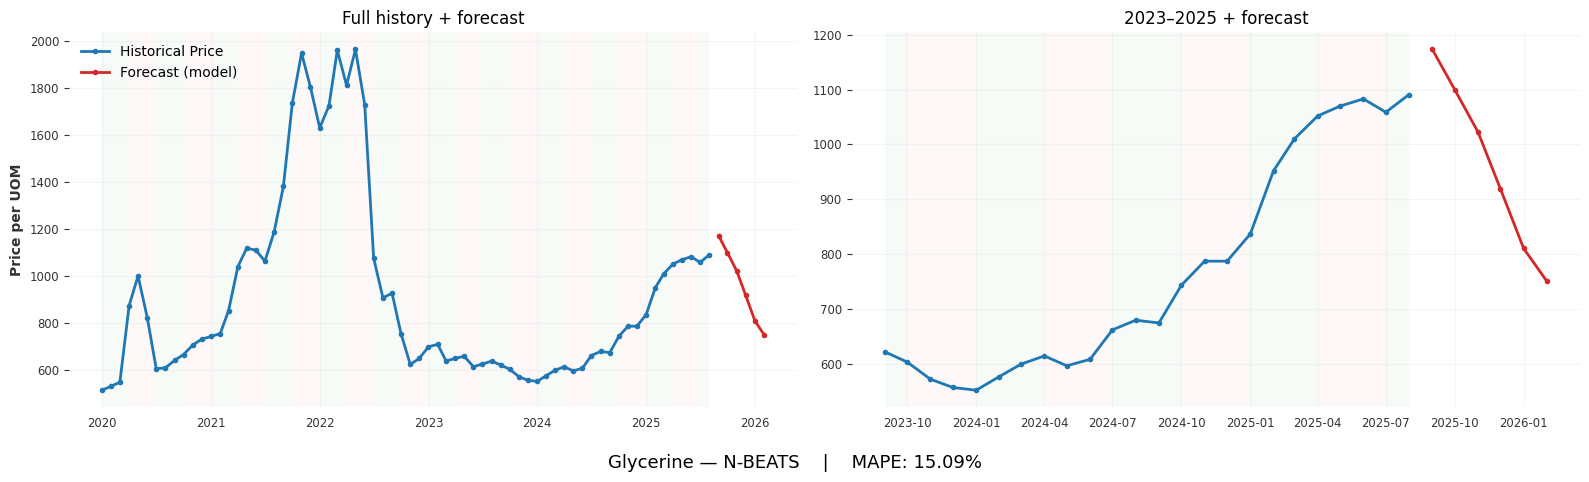

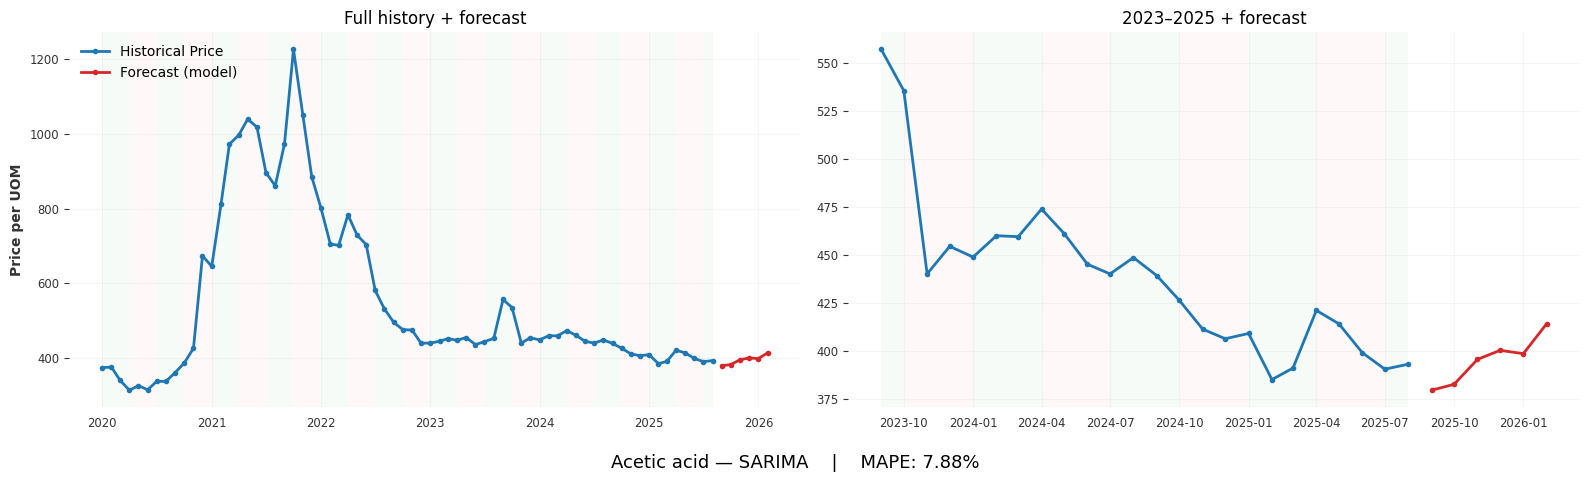

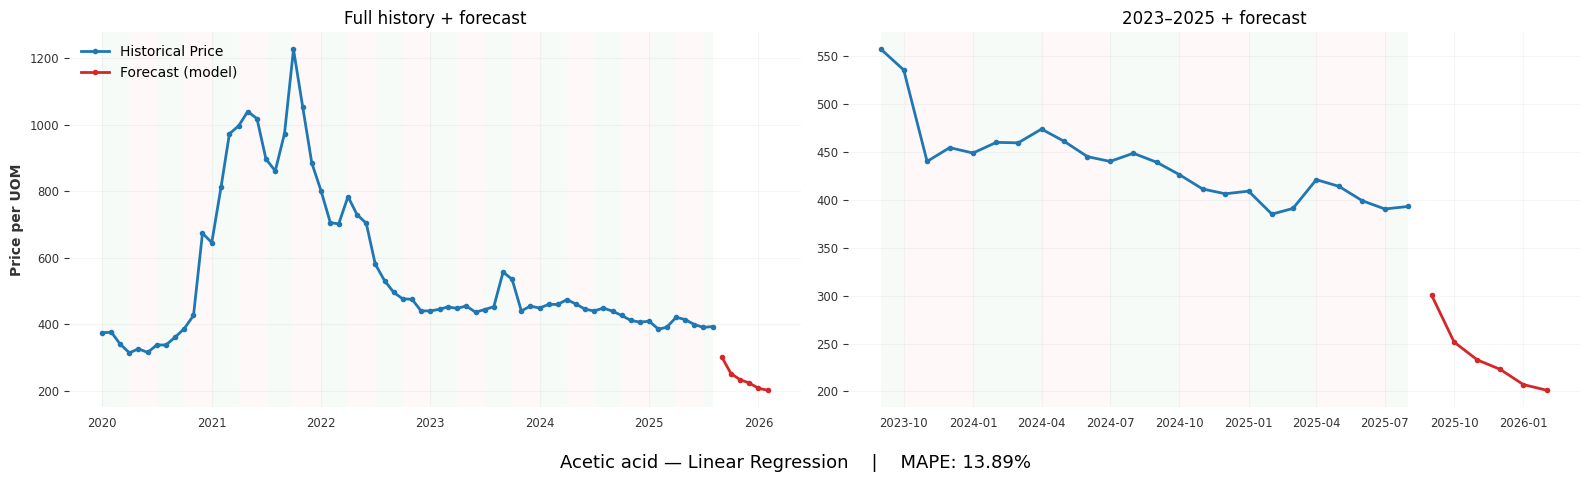

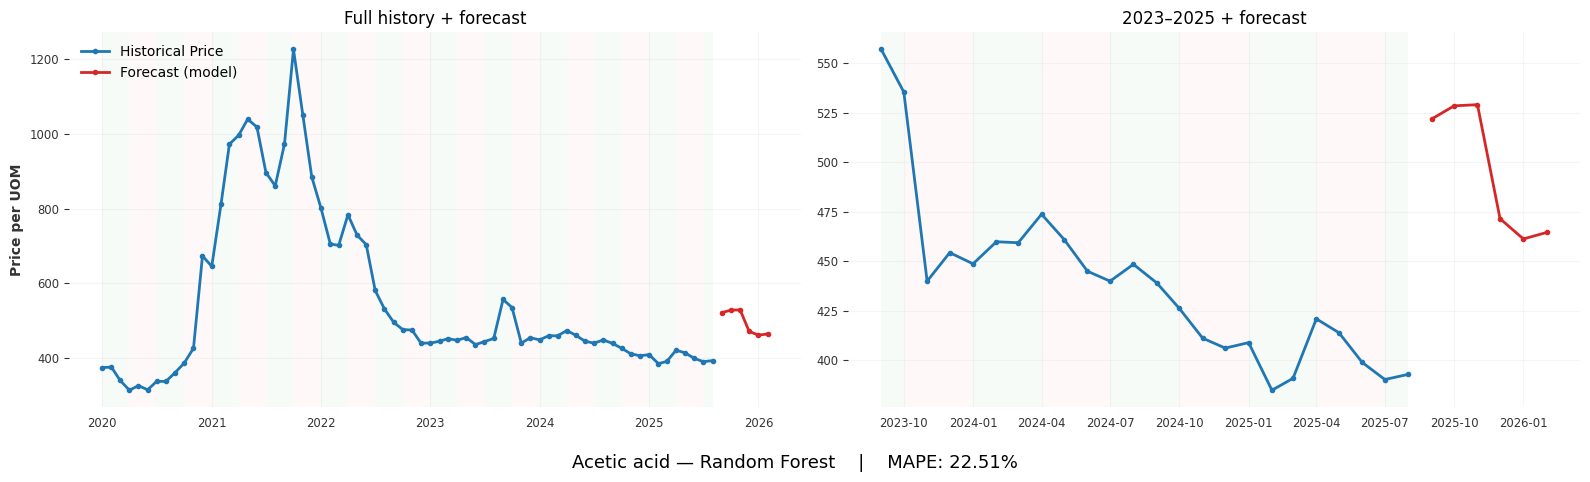

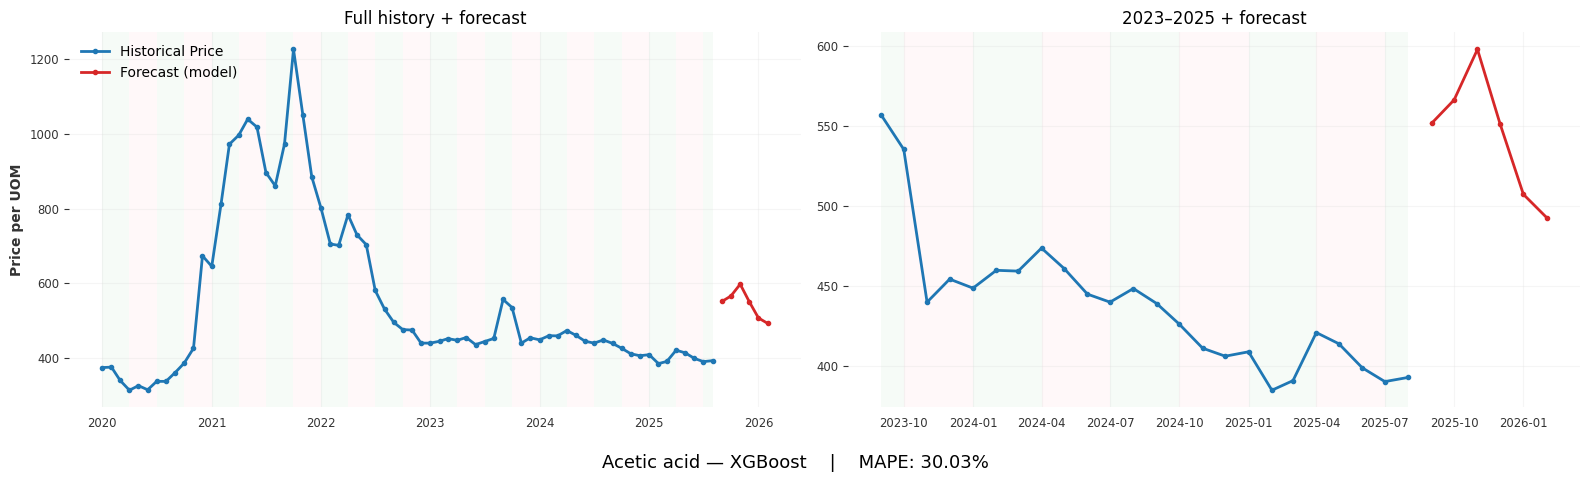

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.599    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.594    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

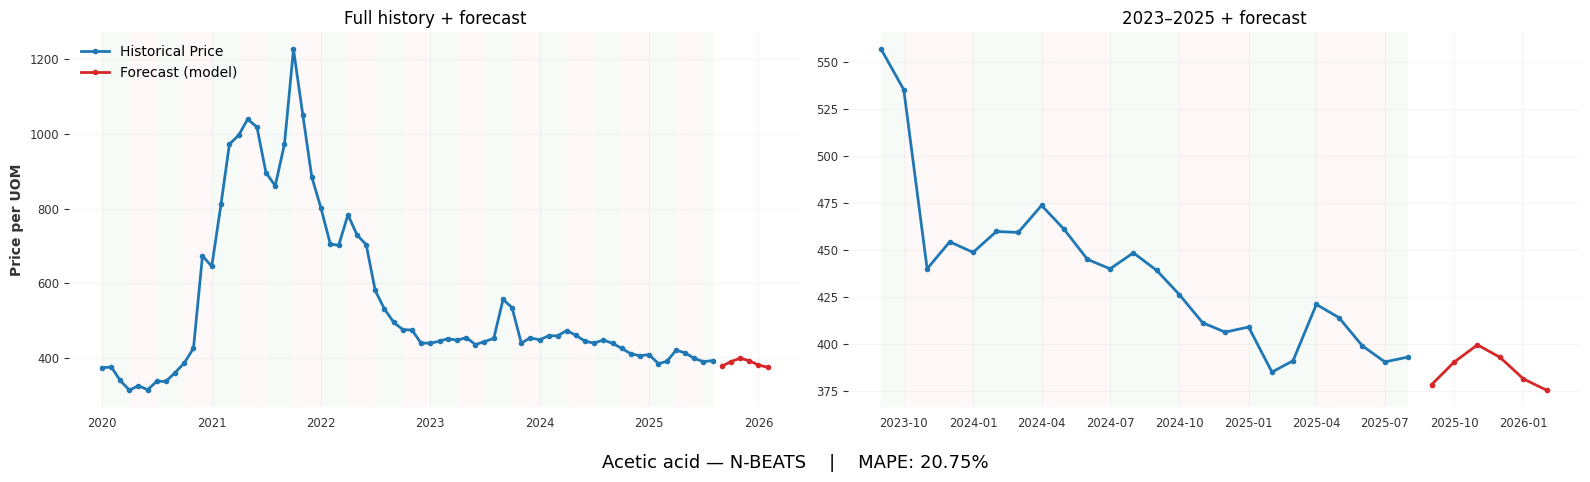

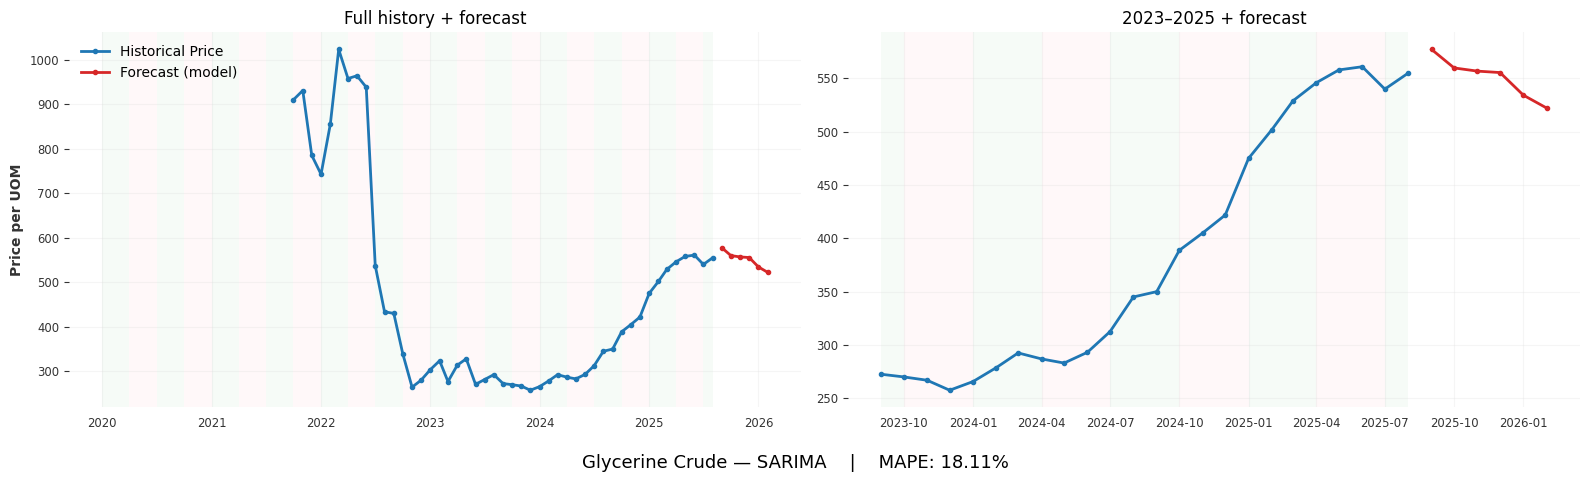

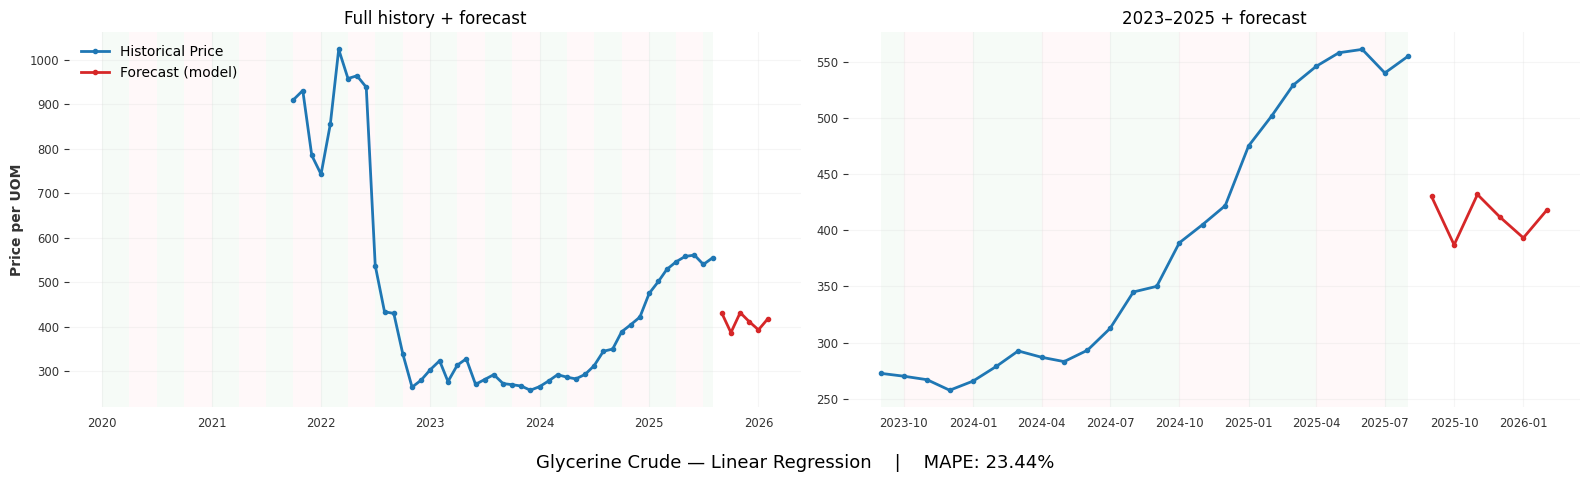

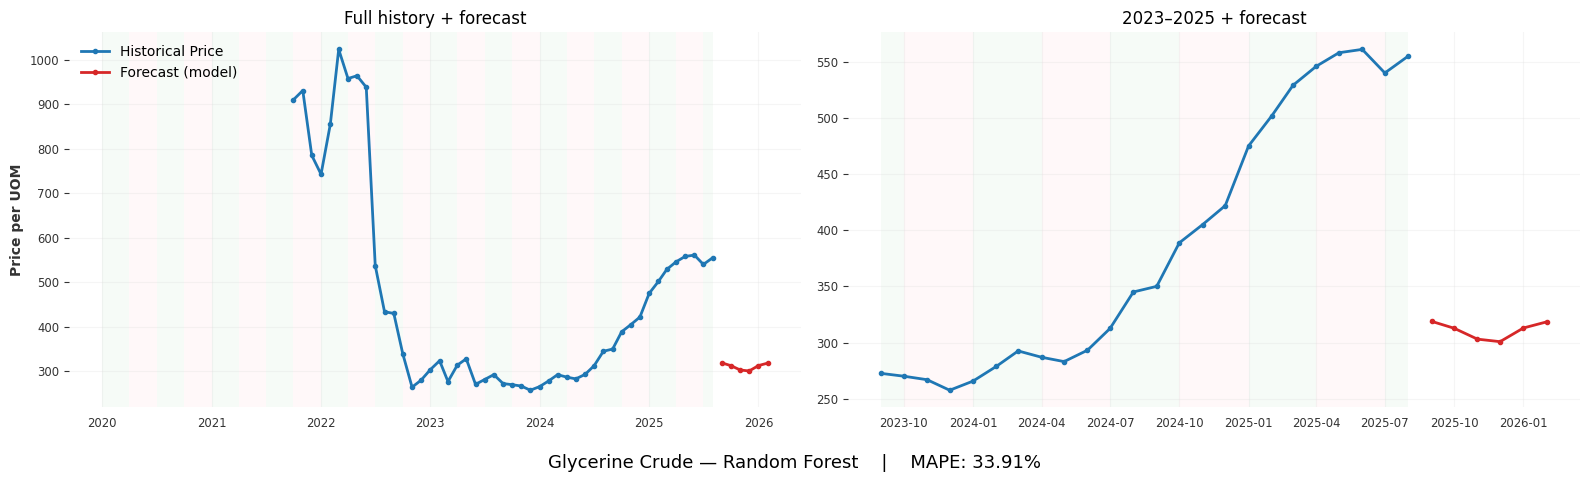

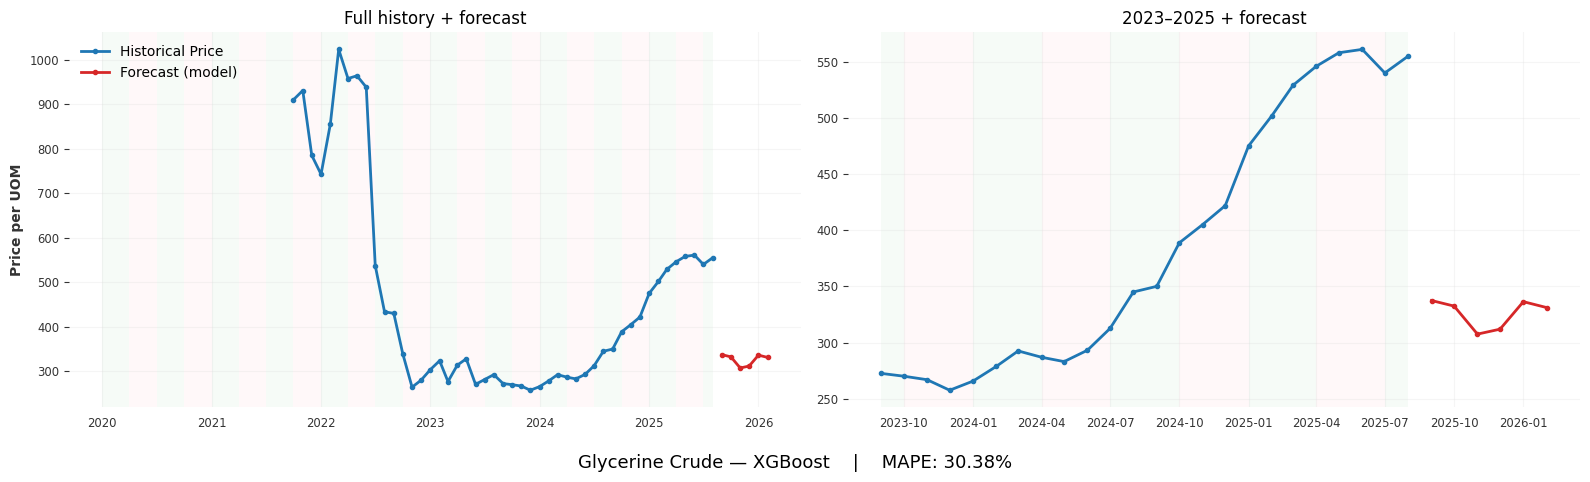

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.599    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.594    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

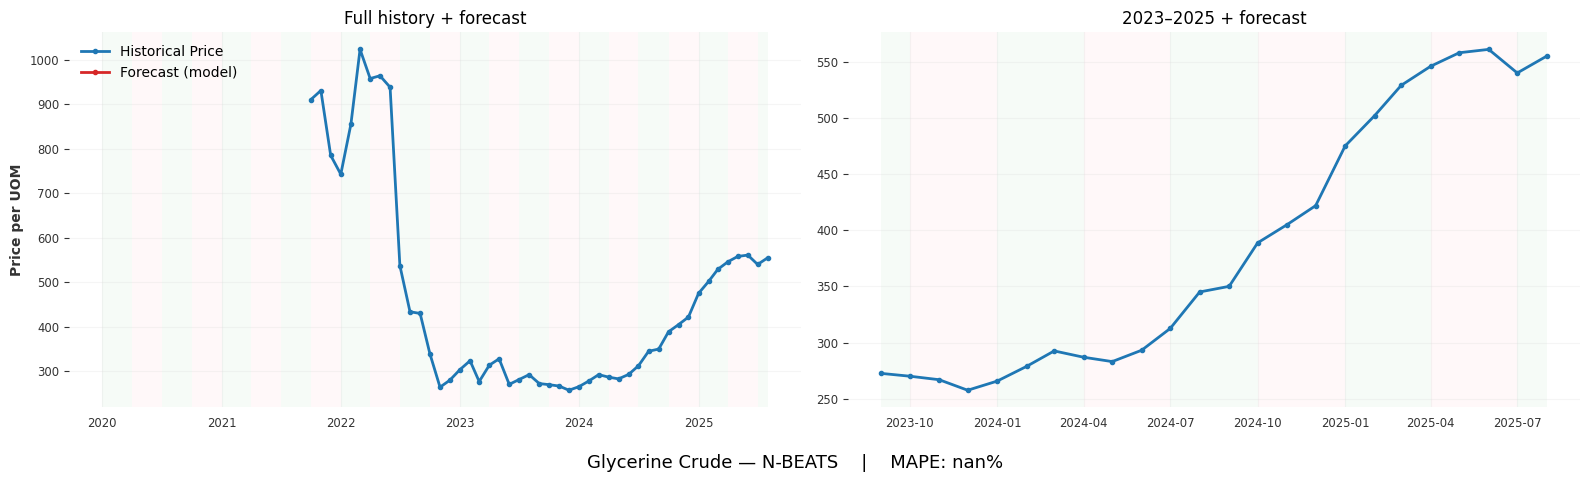

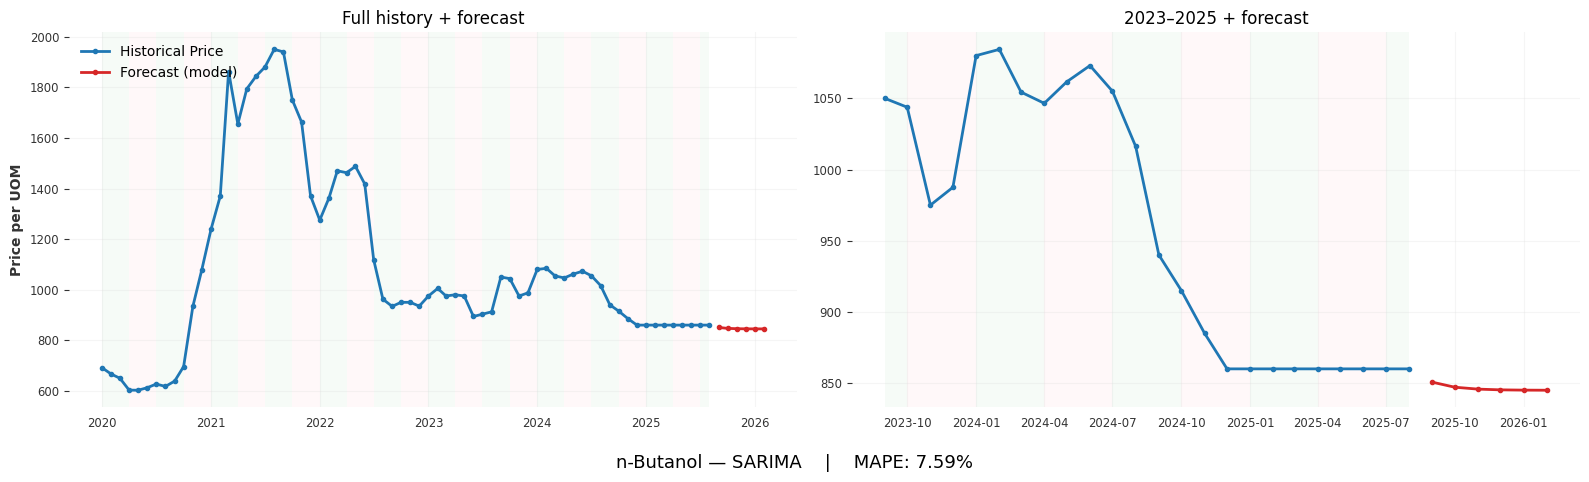

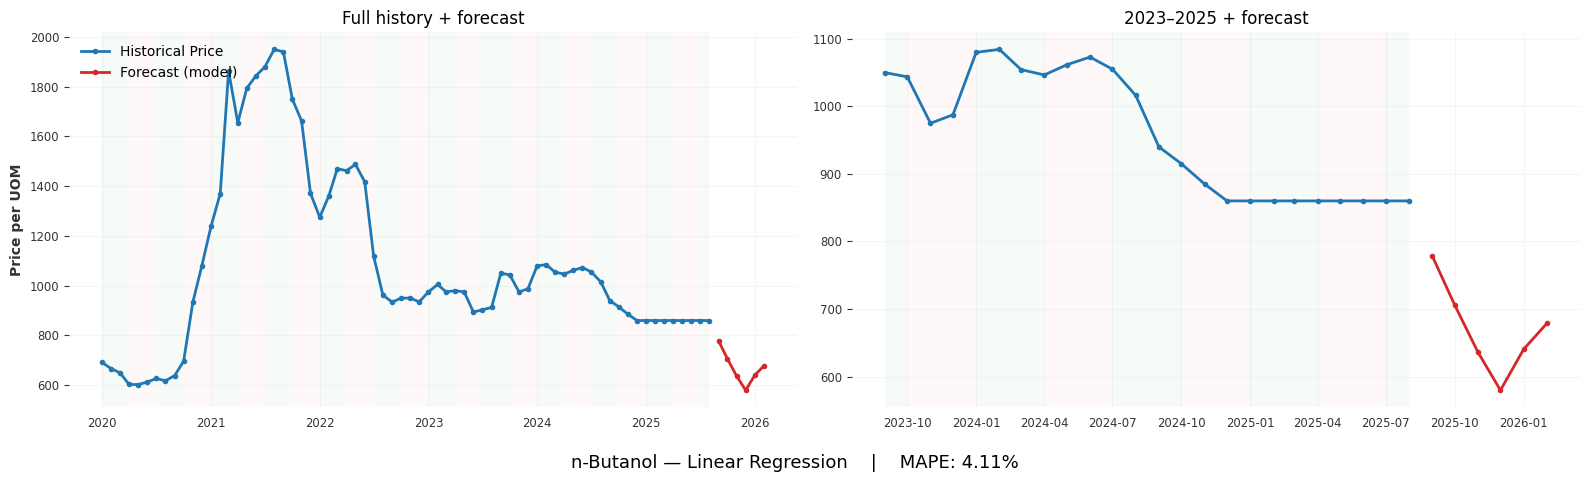

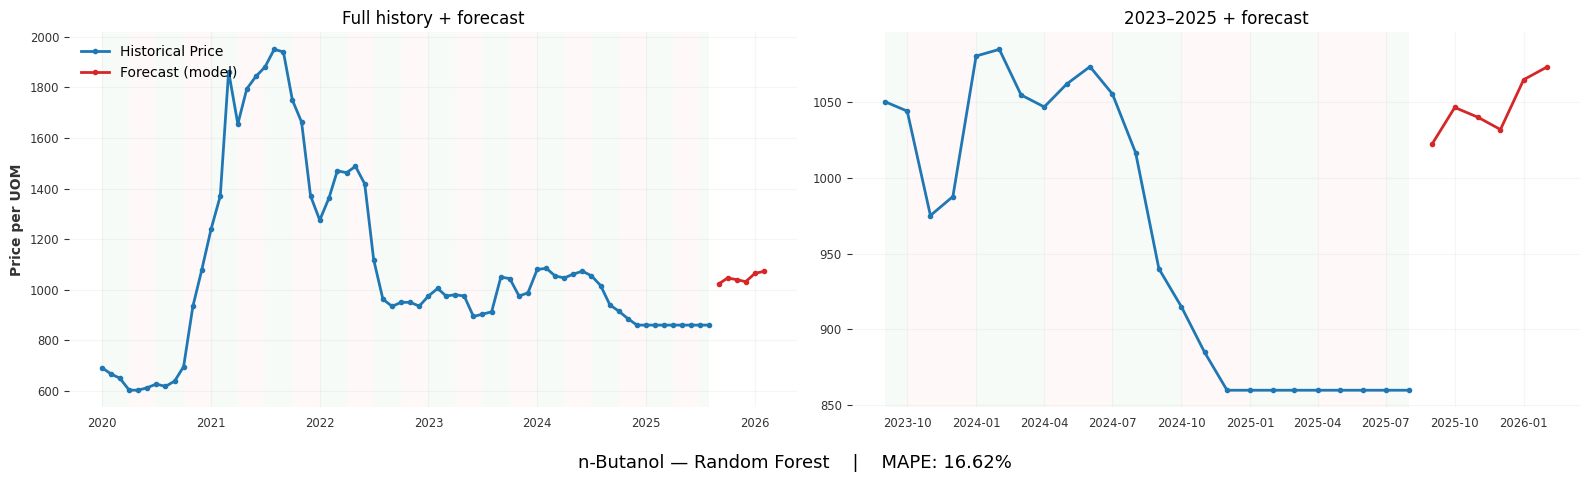

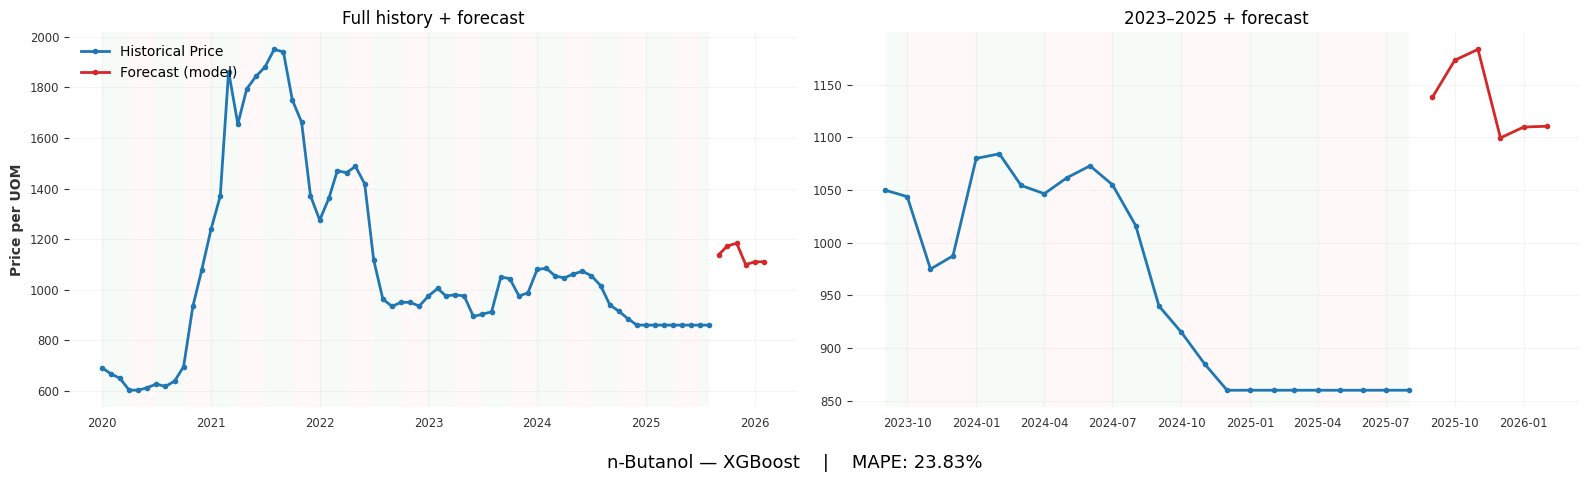

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.599    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.594    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

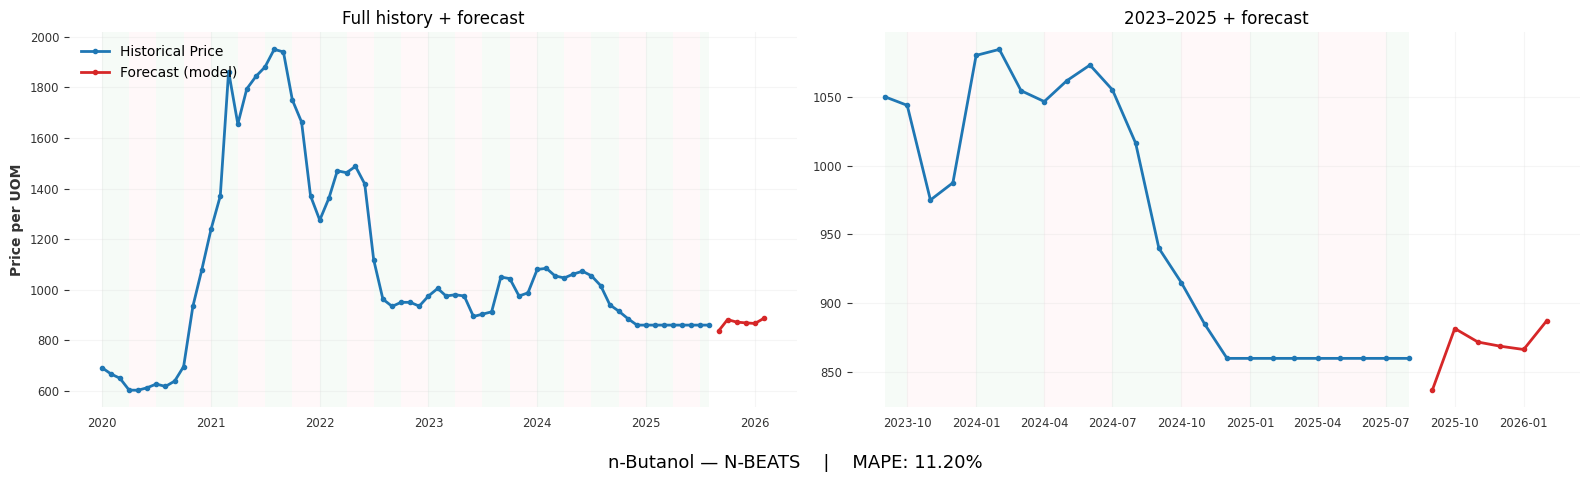

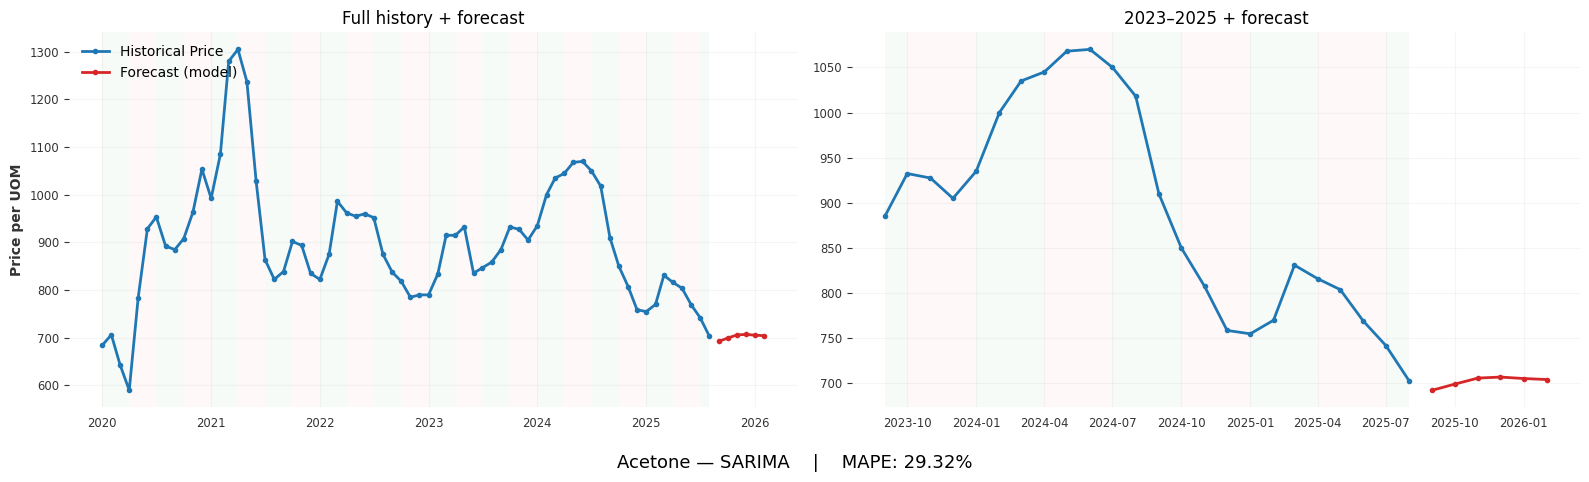

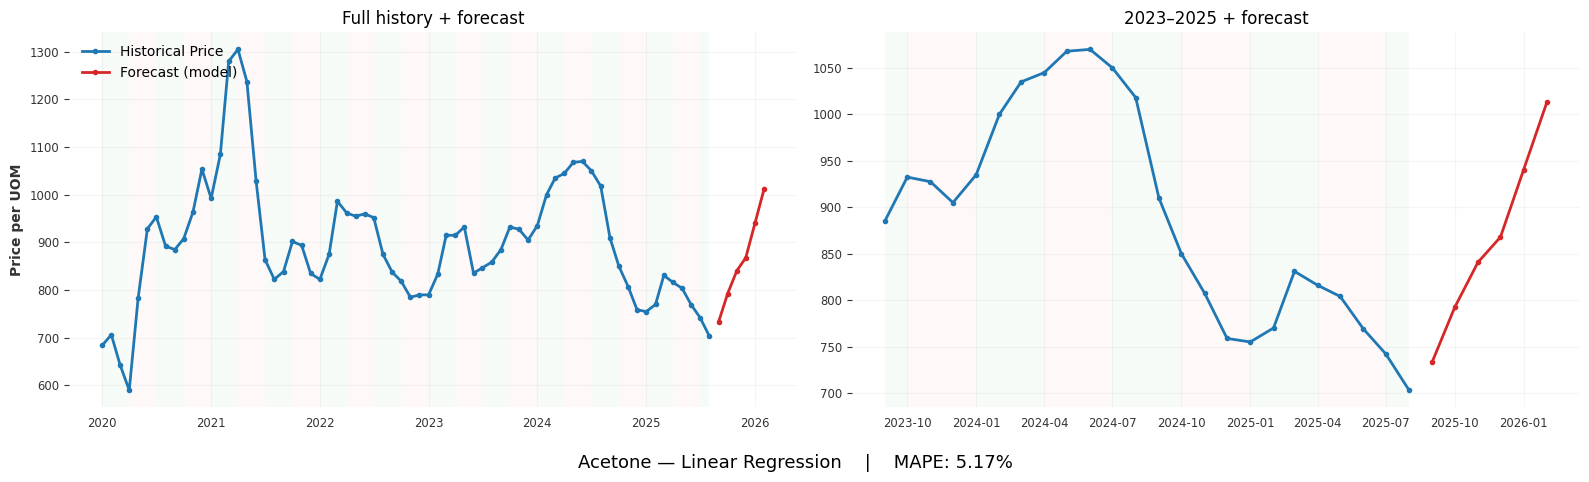

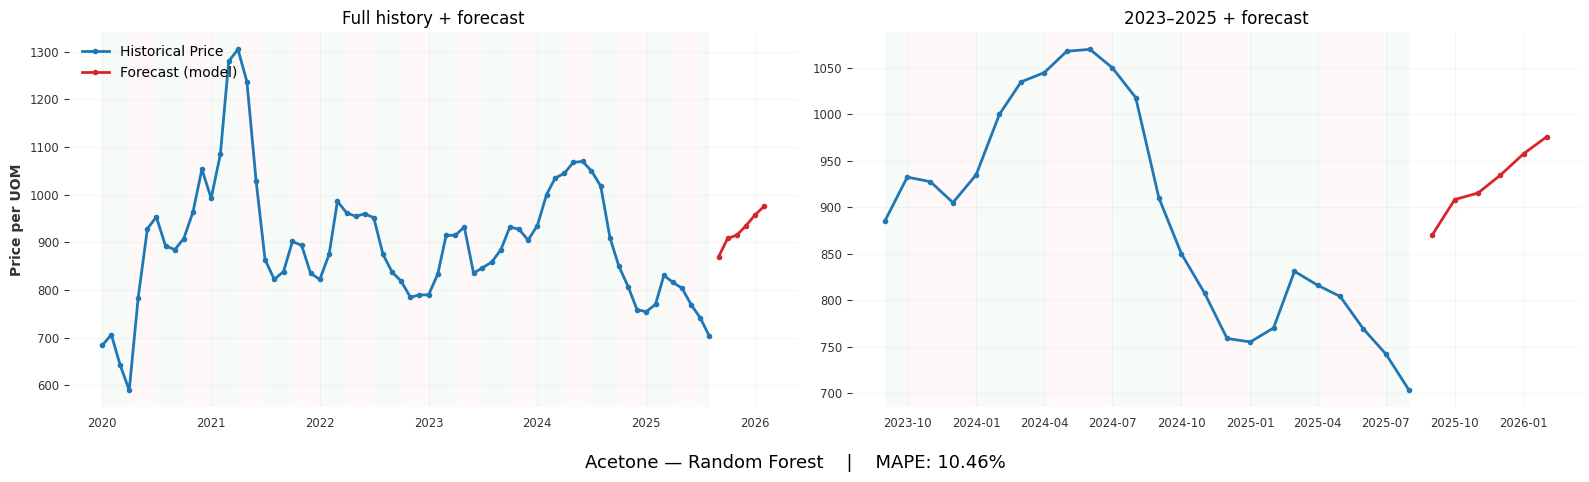

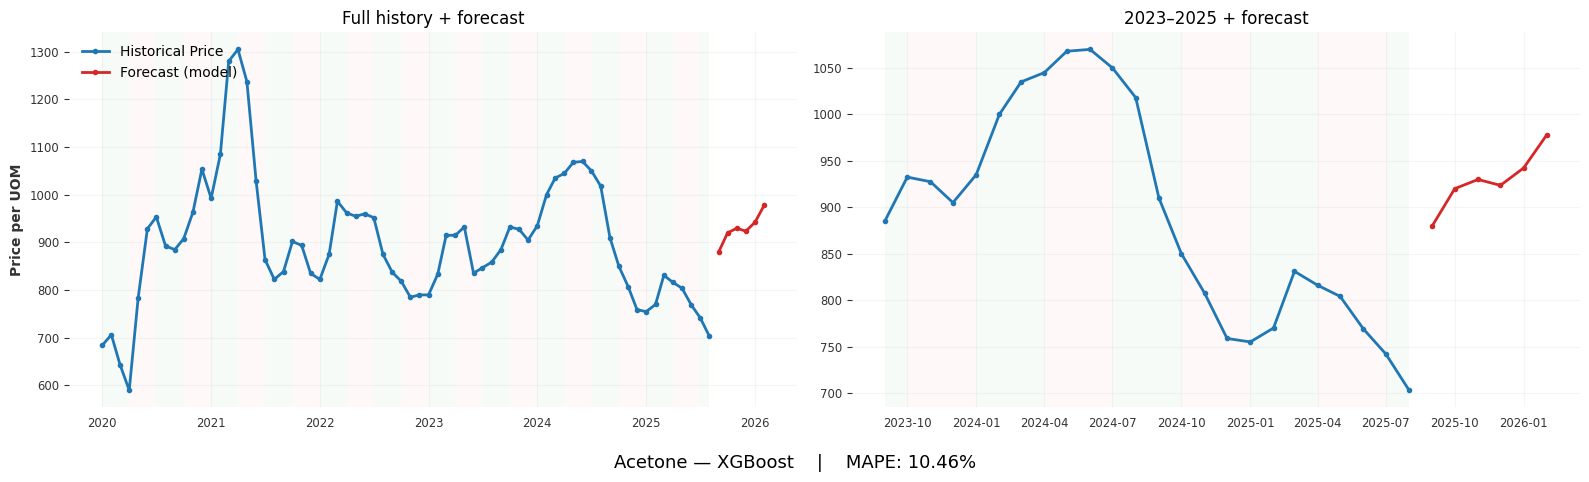

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.599    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.594    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

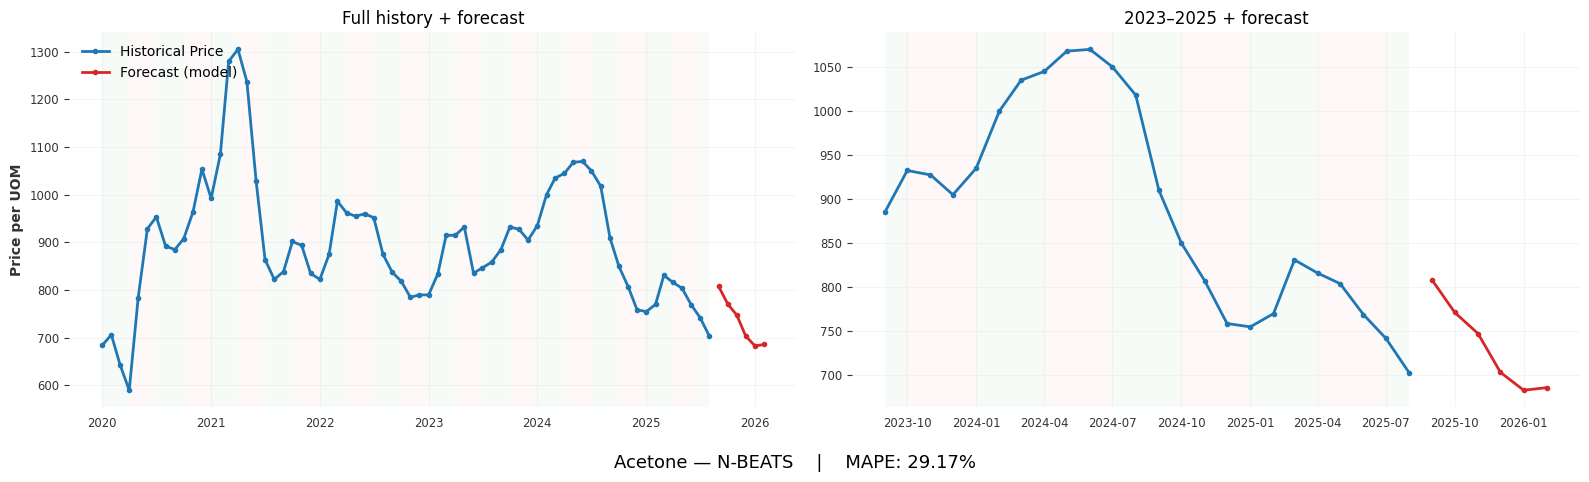

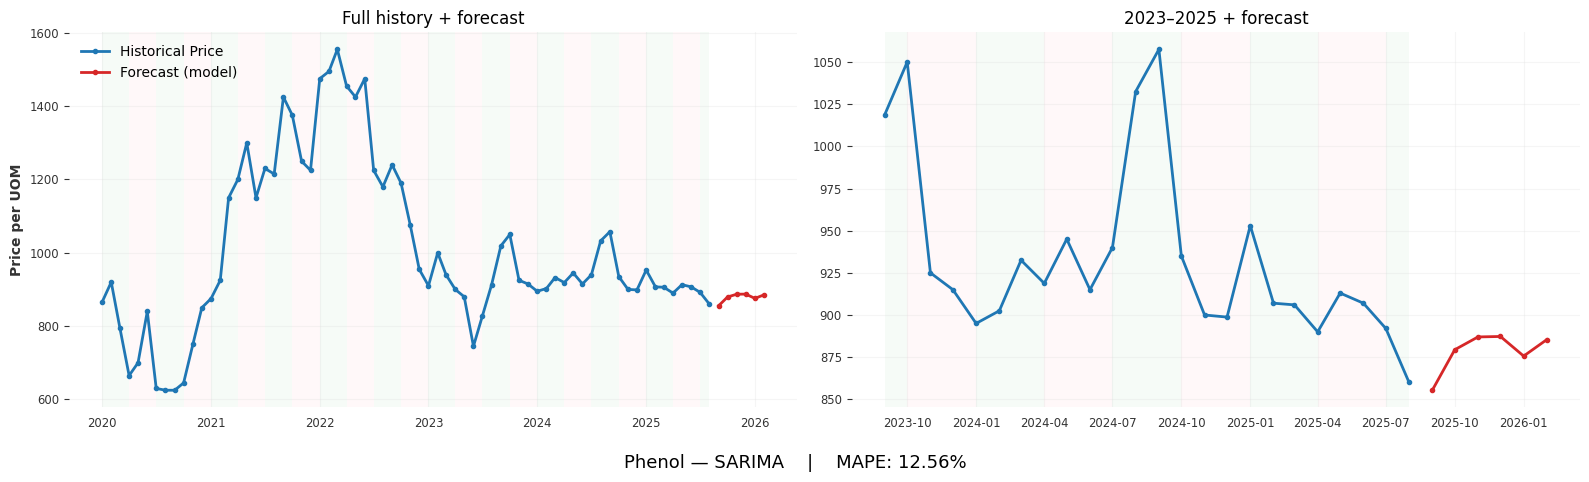

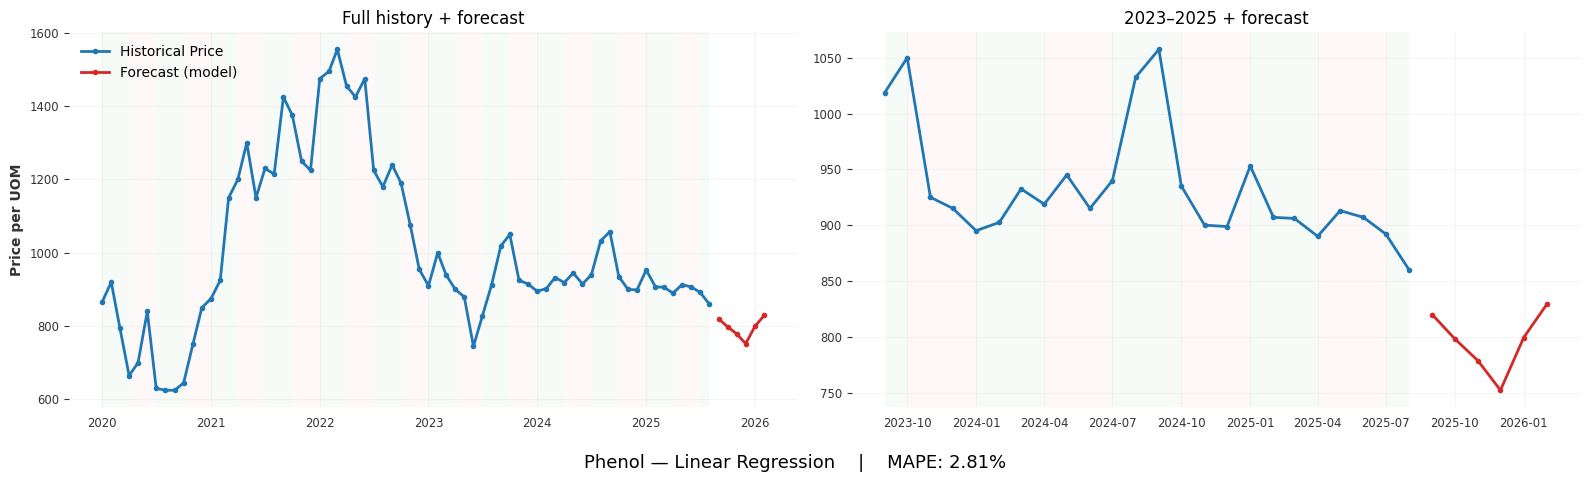

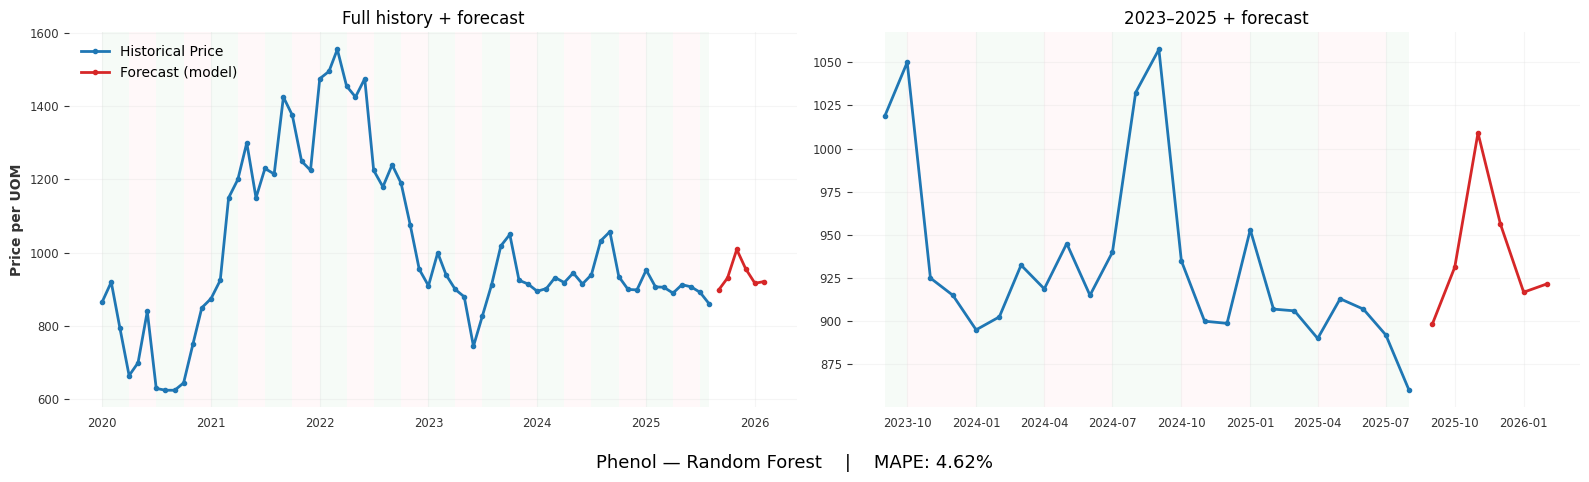

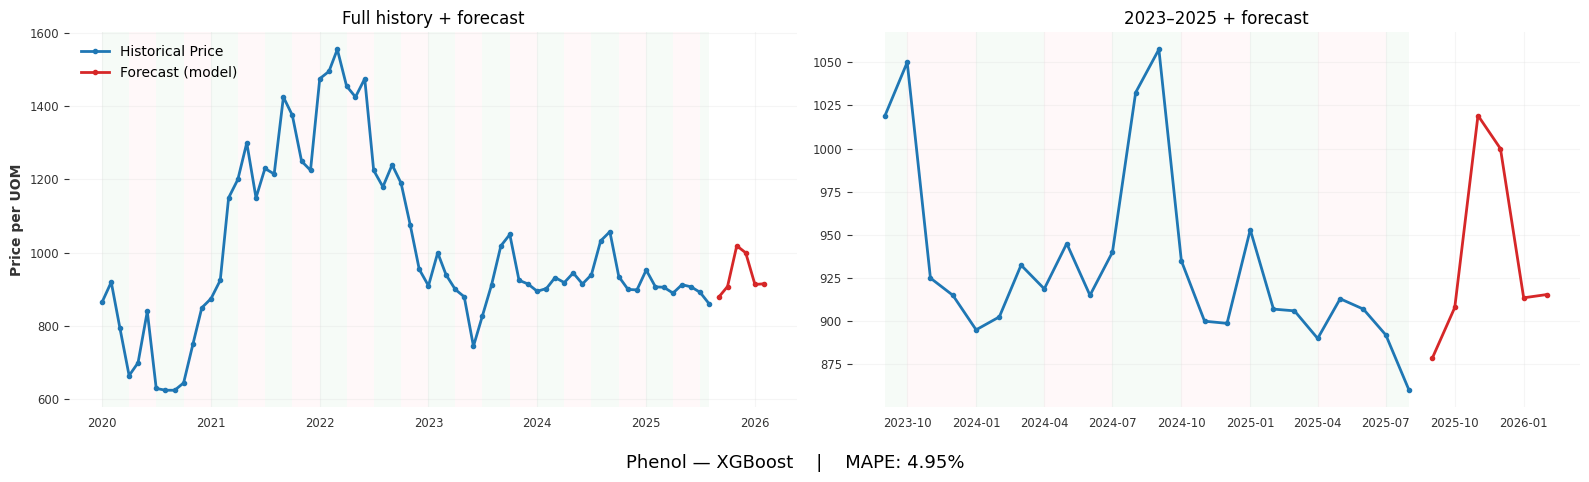

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.599    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.594    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

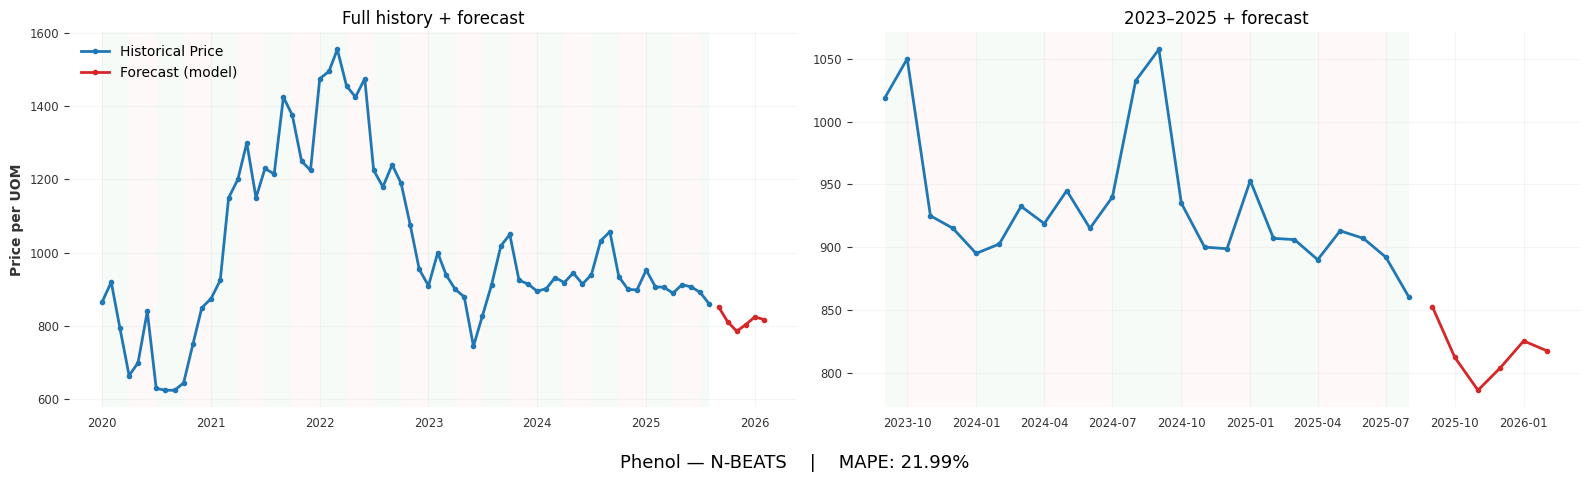

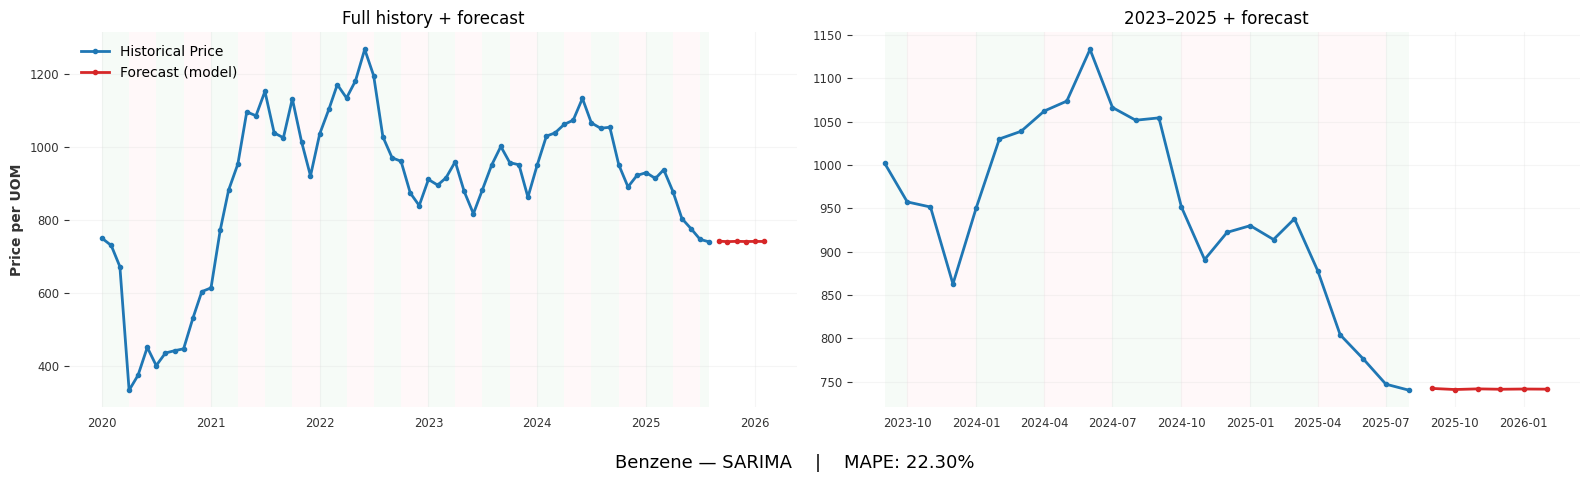

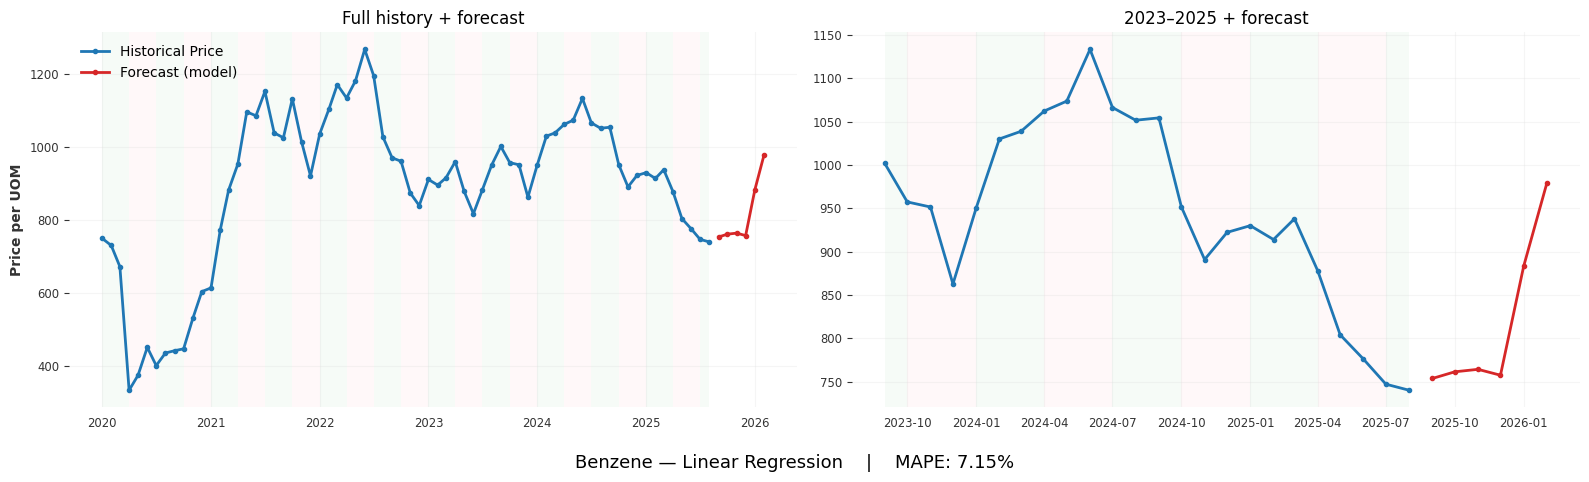

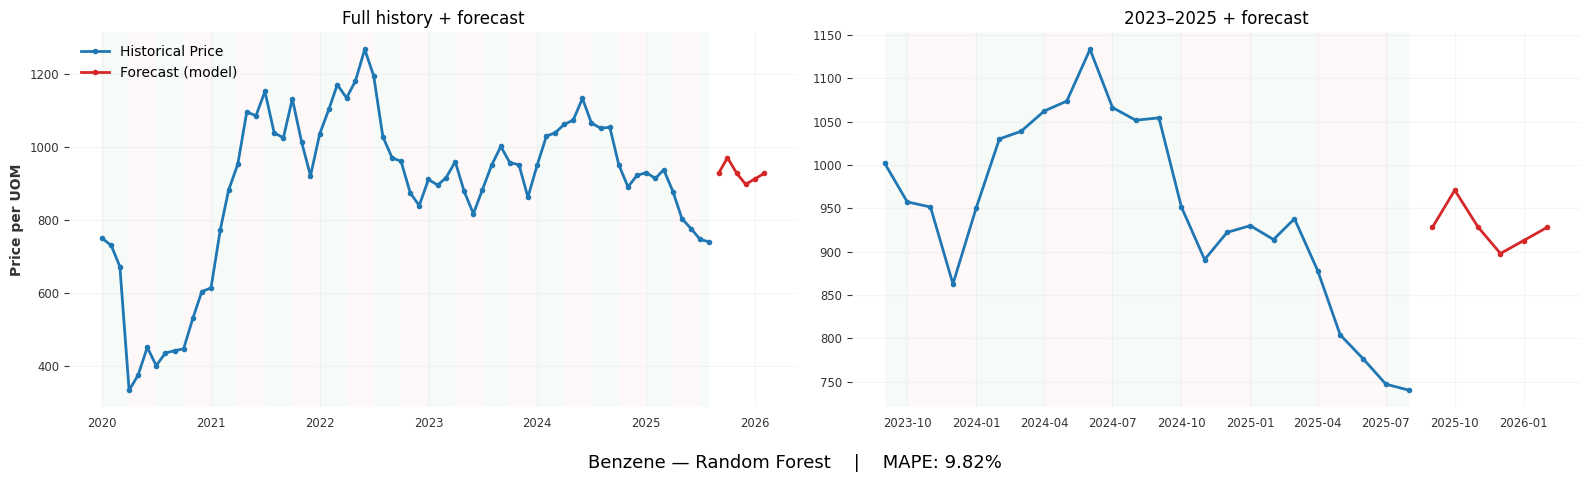

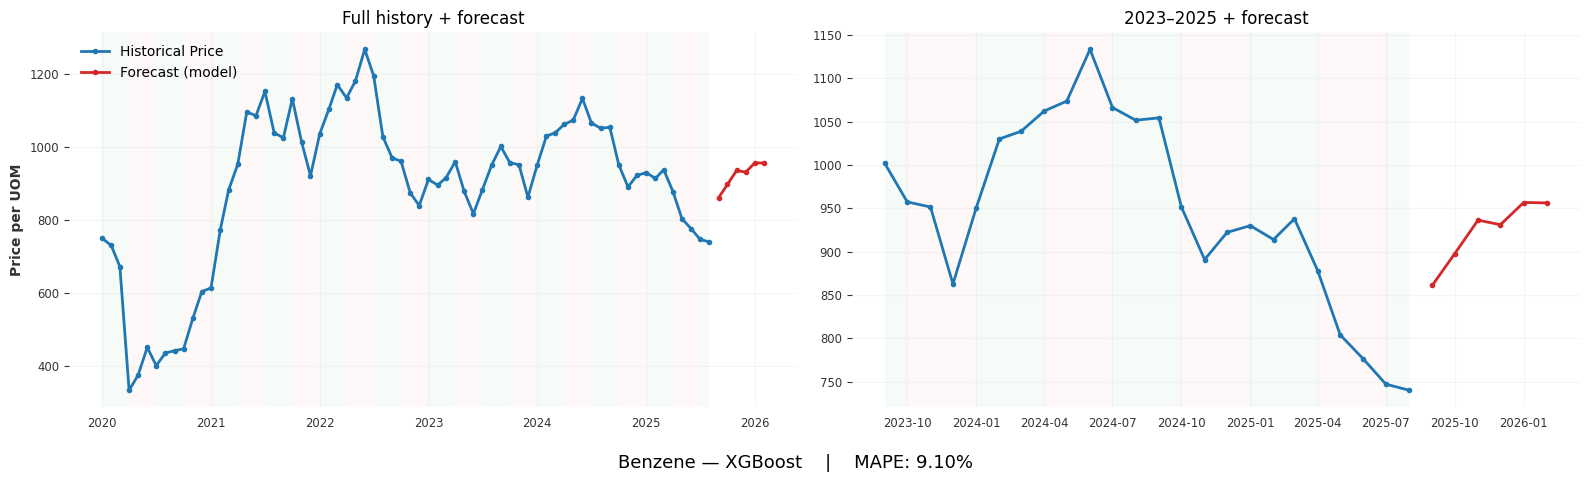

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.599    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.594    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

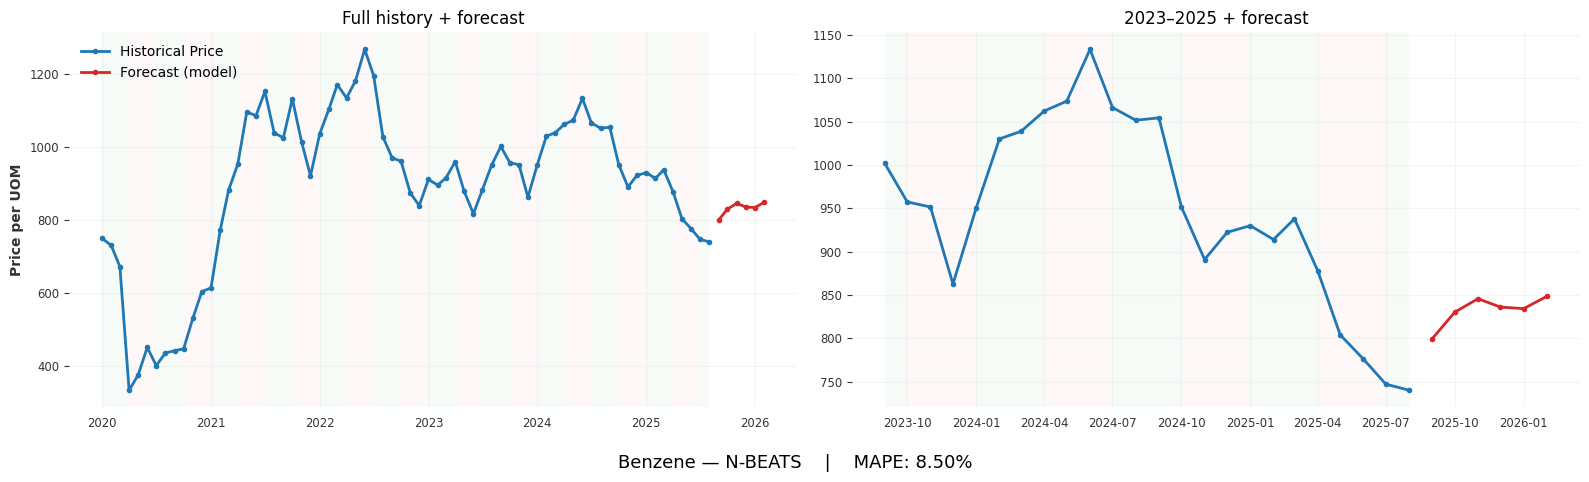

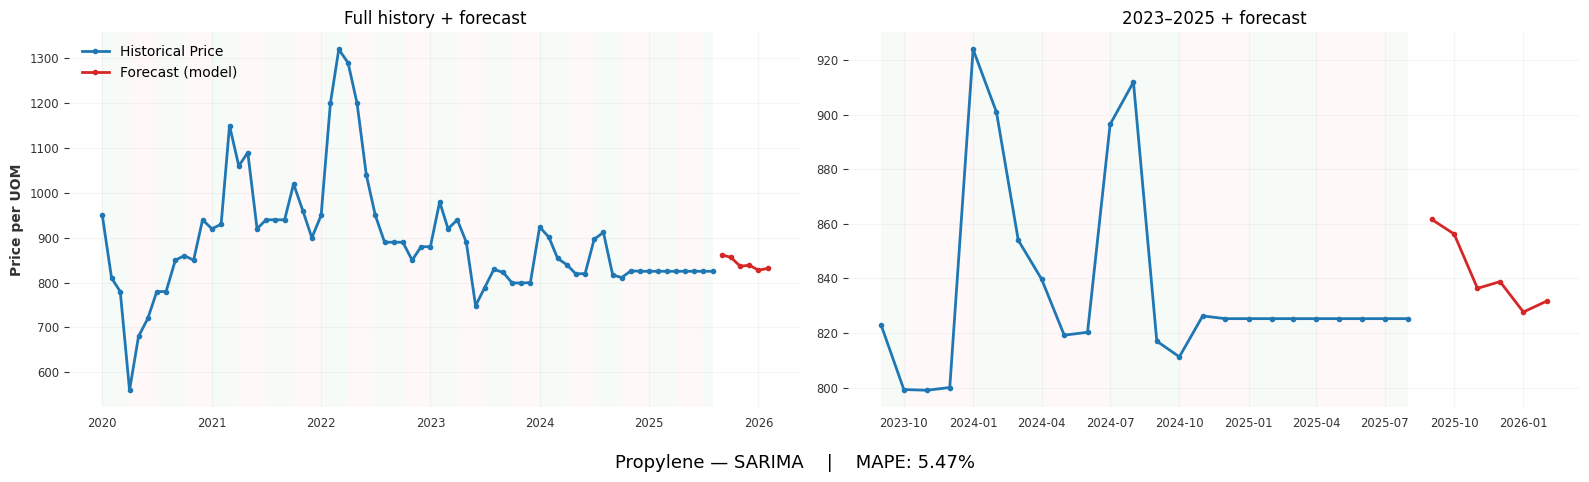

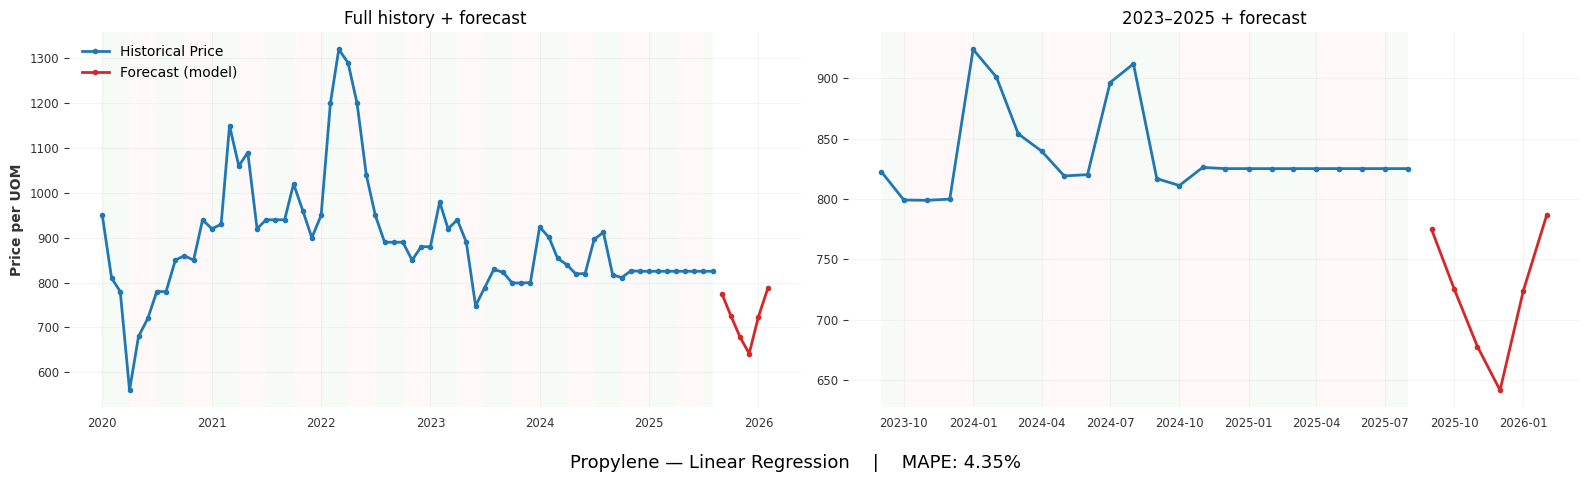

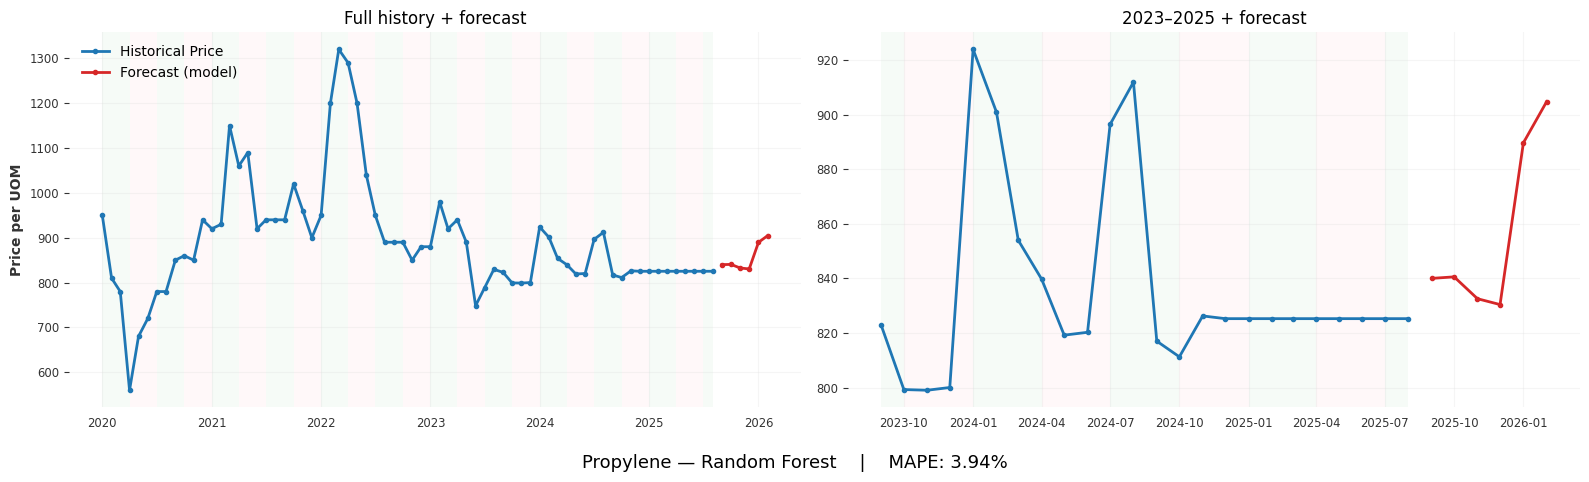

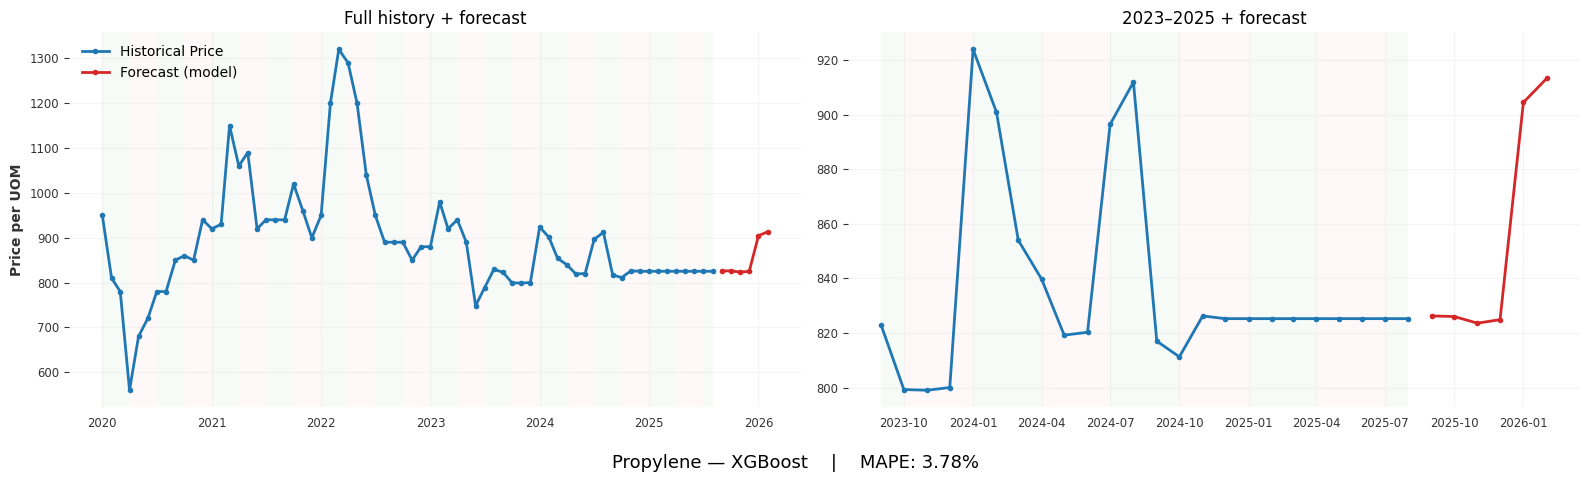

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.599    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.594    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

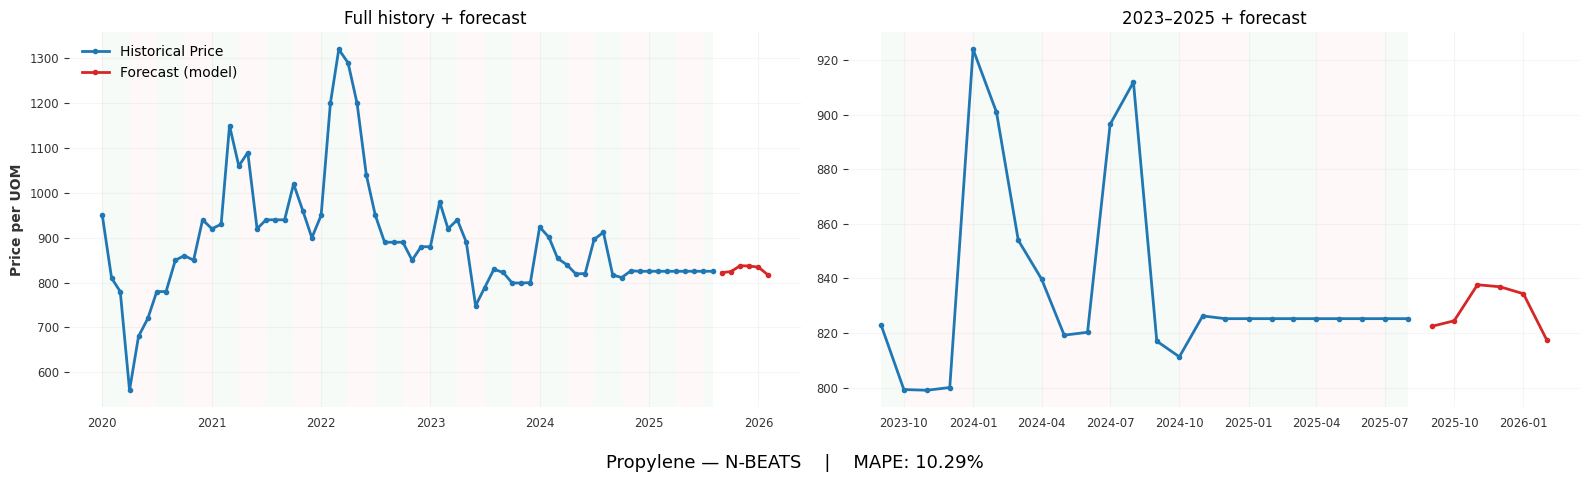

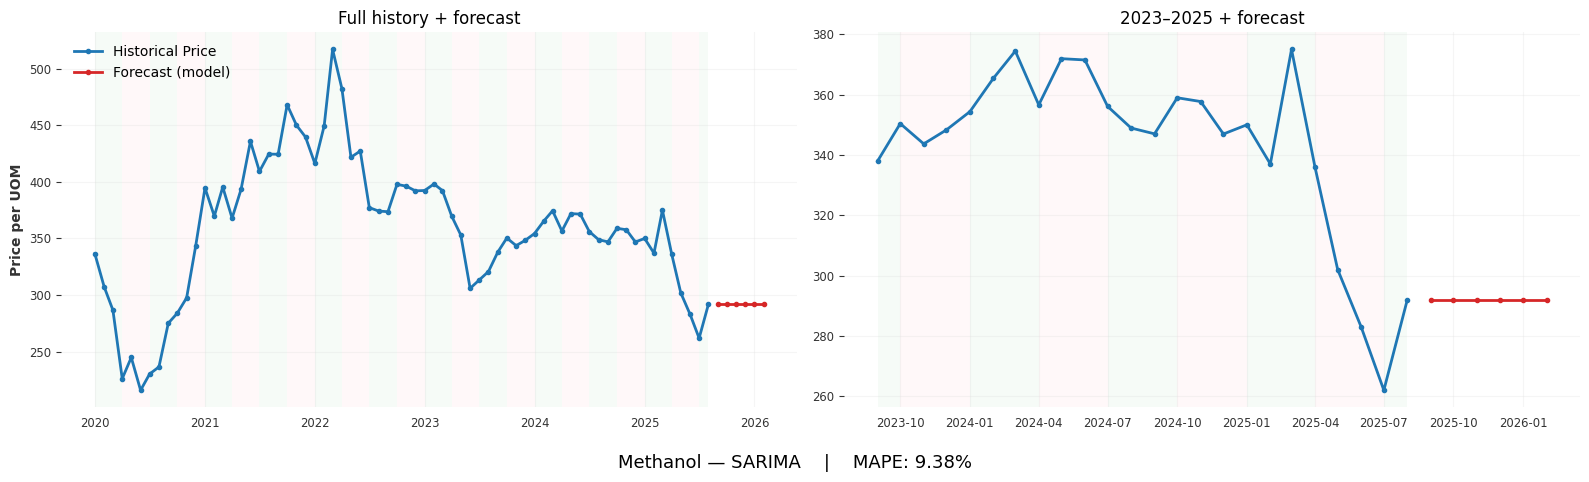

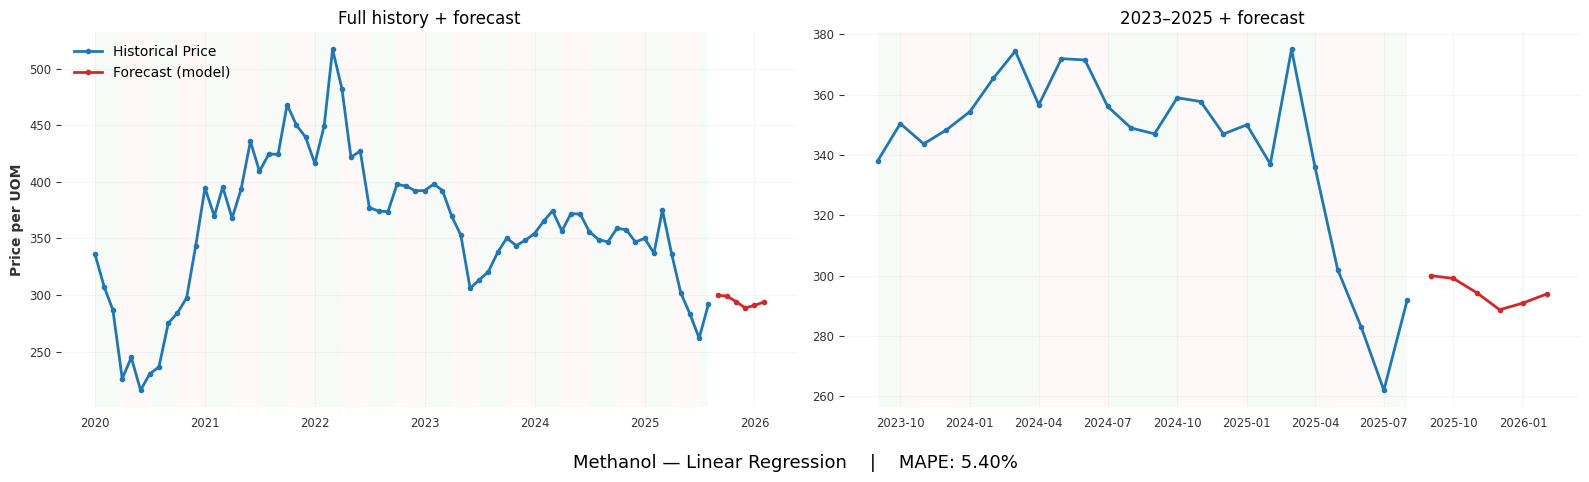

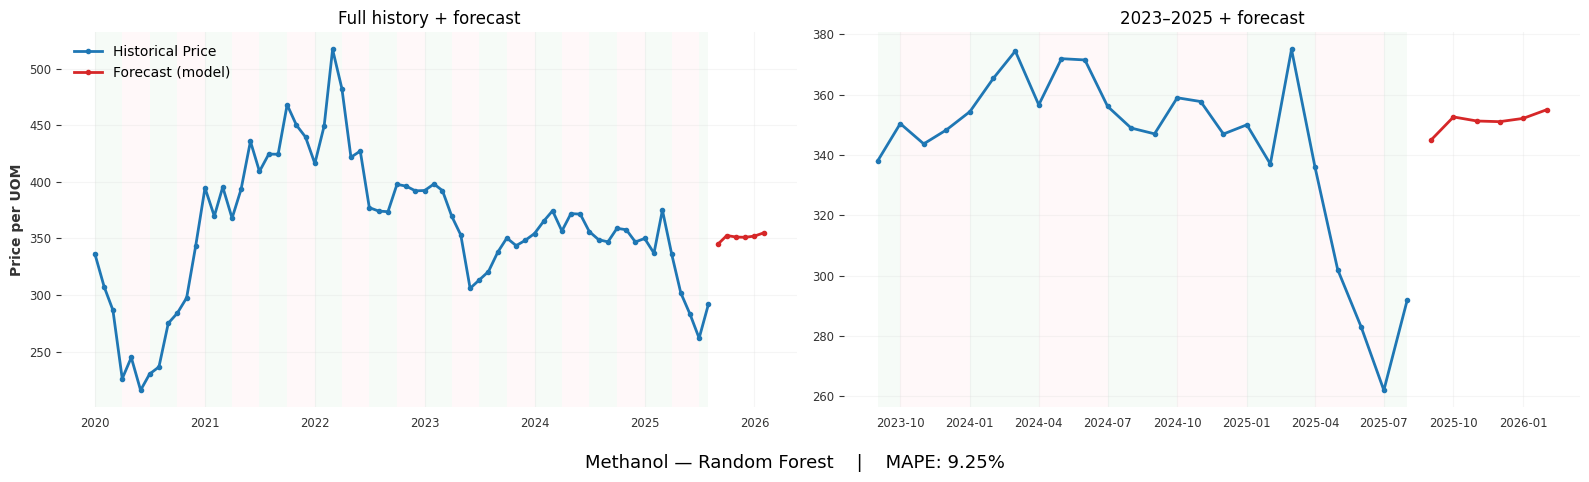

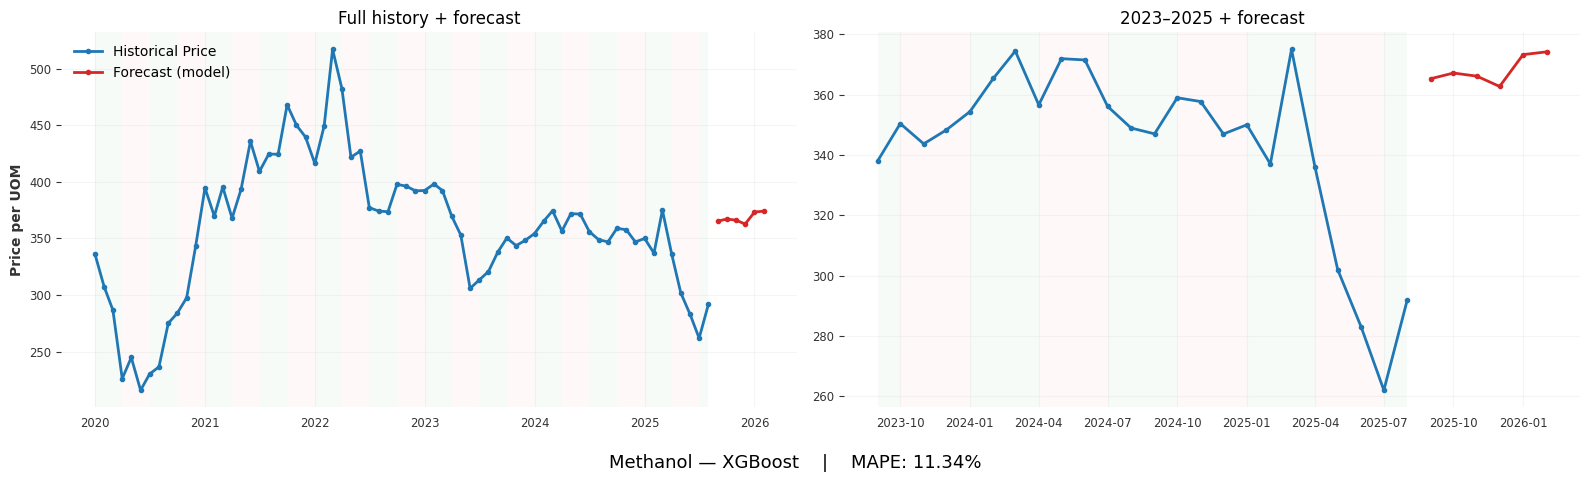

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.599    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.1 M  | train
-------------------------------------------------------------
6.1 M     Trainable params
1.4 K     Non-trainable params
6.1 M     Total params
24.594    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

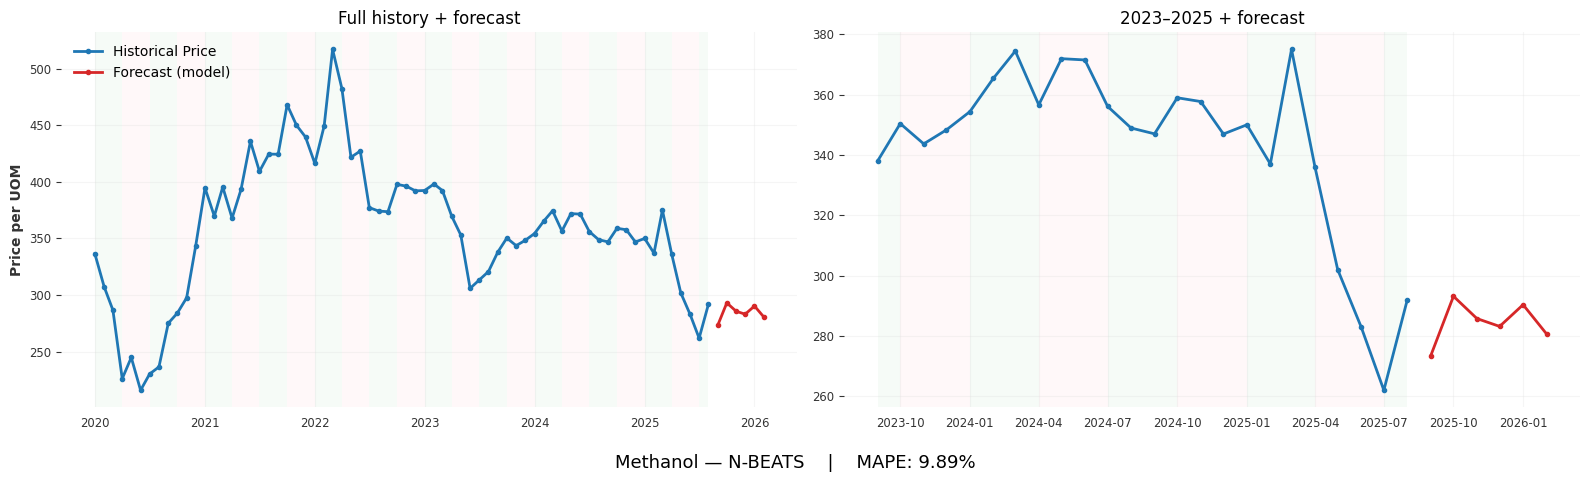

Exp Number                                     Technique Used  \
5            6  SARIMA order=(1, 1, 0), seasonal_order=(1, 0, ...   
6            7                                  Linear Regression   
9           10                                            N-BEATS   
7            8                                      Random Forest   
8            9                                            XGBoost   
21          22                                  Linear Regression   
23          24                                            XGBoost   
22          23                                      Random Forest   
24          25                                            N-BEATS   
20          21  SARIMA order=(2, 1, 0), seasonal_order=(0, 0, ...   
31          32                                  Linear Regression   
34          35                                            N-BEATS   
33          34                                            XGBoost   
32          33                                      Random Forest   
30          31  SARIMA order=(1, 1, 1), seasonal_order=(0, 0, ...   
2            3                                      Random Forest   
3            4                                            XGBoost   
1            2                                  Linear Regression   
4            5                                            N-BEATS   
0            1  SARIMA order=(0, 1, 1), seasonal_order=(0, 0, ...   
10          11  SARIMA order=(0, 1, 1), seasonal_order=(0, 0, ...   
11          12                                  Linear Regression   
13          14                                            XGBoost   
12          13                                      Random Forest   
14          15                                            N-BEATS   
41          42                                  Linear Regression   
42          43                                      Random Forest   
40          41  SARIMA order=(0, 1, 0), seasonal_order=(0, 0, ...   
44          45                                            N-BEATS   
43          44                                            XGBoost   
26          27                                  Linear Regression   
27          28                                      Random Forest   
28          29                                            XGBoost   
25          26  SARIMA order=(0, 1, 0), seasonal_order=(1, 0, ...   
29          30                                            N-BEATS   
38          39                                            XGBoost   
37          38                                      Random Forest   
36          37                                  Linear Regression   
35          36  SARIMA order=(0, 1, 0), seasonal_order=(0, 0, ...   
39          40                                            N-BEATS   
16          17                                  Linear Regression   
15          16  SARIMA order=(1, 1, 0), seasonal_order=(0, 0, ...   
19          20                                            N-BEATS   
17          18                                      Random Forest   
18          19                                            XGBoost   

                                     Data preparation         Material  \
5   Monthly univariate for Acetic acid; train=55 (...      Acetic acid   
6   Lags [1, 2, 3, 6, 12] + month/year; train=44; ...      Acetic acid   
9   Univariate neural forecasting; input_chunk=18/...      Acetic acid   
7   Lags [1, 2, 3, 6, 12] + month/year; train=44; ...      Acetic acid   
8   Lags [1, 2, 3, 6, 12] + month/year; train=44; ...      Acetic acid   
21  Lags [1, 2, 3, 6, 12] + month/year; train=44; ...          Acetone   
23  Lags [1, 2, 3, 6, 12] + month/year; train=44; ...          Acetone   
22  Lags [1, 2, 3, 6, 12] + month/year; train=44; ...          Acetone   
24  Univariate neural forecasting; input_chunk=18/...          Acetone   
20  Monthly univariate for Acetone; train=55 (hold...          Acetone   
31  Lags [1, 2,

Saved consolidated table to: consolidated_results.xlsx


In [ ]:
# ===== Cell 3: load data, fit/forecast, plot, collect results =====

# ---------- Load ----------
FILE_PATH = find_input_file(FILE_PATH_CANDIDATES)
raw = pd.read_excel(FILE_PATH, sheet_name=SHEET)

# Build monthly datetime index
raw["date"] = pd.to_datetime(
    raw[DATE_YEAR_COL].astype(str) + "-" + raw[DATE_MONTH_COL].astype(str) + "-01",
    errors="coerce"
)
raw = (raw.dropna(subset=["date"])
          .sort_values("date")
          .reset_index(drop=True)
          .set_index("date"))

# Detect materials
material_cols = [c for c in raw.columns if c.startswith(COL_PREFIX)]
df = raw[material_cols].rename(columns=lambda c: c.replace(COL_PREFIX, "").strip())

# Force monthly freq; interpolate for smooth plotting/ML lags
df = df.asfreq("MS").sort_index()
df_plot = df.interpolate(method="time")

print("Materials detected:", ", ".join(df.columns))

# ---------- Runners ----------
def run_sarima(material, series):
    # split
    if len(series) < (SEASONAL_PERIOD + TEST_HORIZON + 3):
        raise ValueError("Insufficient history for SARIMA.")
    train = series.iloc[:-TEST_HORIZON]
    test  = series.iloc[-TEST_HORIZON:]
    train_fit = np.log1p(train) if LOG_TRANSFORM else train
    full_fit  = np.log1p(series) if LOG_TRANSFORM else series

    order, sorder = sarimax_auto(train_fit, seasonal_period=SEASONAL_PERIOD)
    if order is None:
        raise RuntimeError("No SARIMA orders found.")
    m1 = SARIMAX(train_fit, order=order, seasonal_order=sorder,
                 enforce_stationarity=True, enforce_invertibility=True).fit(disp=False)
    test_fc_fit = m1.get_forecast(steps=TEST_HORIZON).predicted_mean.values
    test_fc = np.expm1(test_fc_fit) if LOG_TRANSFORM else test_fc_fit
    if is_explosive(test_fc, train):
        test_fc = seasonal_naive(train, TEST_HORIZON, m=SEASONAL_PERIOD)
    mape_val = safe_mape(test.values, test_fc)

    m2 = SARIMAX(full_fit, order=order, seasonal_order=sorder,
                 enforce_stationarity=True, enforce_invertibility=True).fit(disp=False)
    fut_fc_fit = m2.get_forecast(steps=FORECAST_HORIZON).predicted_mean.values
    fut_fc = np.expm1(fut_fc_fit) if LOG_TRANSFORM else fut_fc_fit
    if is_explosive(fut_fc, series):
        fut_fc = seasonal_naive(series, FORECAST_HORIZON, m=SEASONAL_PERIOD)

    details = f"SARIMA order={order}, seasonal_order={sorder}"
    prep = (f"Monthly univariate for {material}; train={len(train)} (hold-out {TEST_HORIZON}); "
            f"log1p={LOG_TRANSFORM}; fallback seasonal-naive if explosive.")
    return test.index, test.values, test_fc, fut_fc, mape_val, details, prep, len(train)

def run_ml(material, series, model_name):
    min_needed = max(LAGS) + TEST_HORIZON + 6
    if len(series) < min_needed:
        raise ValueError("Insufficient history for ML model.")
    feat = make_features(series, lags=LAGS)
    X, y = feat.drop(columns=["y"]), feat["y"]
    X.index = y.index = feat.index
    train_idx = y.index[:-TEST_HORIZON]
    test_idx  = y.index[-TEST_HORIZON:]
    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]

    model = get_model(model_name)
    model.fit(X_train, y_train)
    test_fc = model.predict(X_test)
    mape_val = safe_mape(y_test.values, test_fc)

    # recursive future using lags
    future_vals = []
    last_known = series.copy()
    for step in range(FORECAST_HORIZON):
        next_date = last_known.index[-1] + pd.offsets.MonthBegin(1)
        feat_row = {f"lag_{lag}": last_known.iloc[-lag] for lag in LAGS}
        feat_row["month"] = next_date.month
        feat_row["year"]  = next_date.year
        X_future = pd.DataFrame([feat_row], index=[next_date])
        y_pred = float(model.predict(X_future)[0])
        future_vals.append(y_pred)
        last_known.loc[next_date] = y_pred
    fut_fc = np.array(future_vals)

    details = model_name
    prep = (f"Lags {LAGS} + month/year; train={len(train_idx)}; "
            f"time-ordered split; recursive {FORECAST_HORIZON}-step forecast.")
    return test_idx, y_test.values, test_fc, fut_fc, mape_val, details, prep, len(train_idx)

# Optional: N-BEATS (Darts)
if INCLUDE_NBEATS:
    from darts import TimeSeries
    from darts.metrics import mape as darts_mape
    from darts.models import NBEATSModel

    def run_nbeats(material, series):
        if len(series) < 12 + TEST_HORIZON + 6:
            raise ValueError("Insufficient history for N-BEATS.")
        ts_all = TimeSeries.from_series(series)
        train_ts, test_ts = ts_all[:-TEST_HORIZON], ts_all[-TEST_HORIZON:]
        in_len_eval = max(6, min(18, len(train_ts) - TEST_HORIZON if len(train_ts) > TEST_HORIZON else 12))
        in_len_full = max(6, min(18, len(ts_all) - TEST_HORIZON if len(ts_all) > TEST_HORIZON else 12))

        model_eval = NBEATSModel(
            input_chunk_length=in_len_eval, output_chunk_length=TEST_HORIZON,
            n_epochs=100, batch_size=32, optimizer_kwargs={"lr":1e-3}, random_state=42)
        model_eval.fit(train_ts)
        pred_eval = model_eval.predict(TEST_HORIZON)

        model_full = NBEATSModel(
            input_chunk_length=in_len_full, output_chunk_length=FORECAST_HORIZON,
            n_epochs=100, batch_size=32, optimizer_kwargs={"lr":1e-3}, random_state=42)
        model_full.fit(ts_all)
        pred_future = model_full.predict(FORECAST_HORIZON)

        test_pd = pd.Series(test_ts.values().flatten(), index=test_ts.time_index)
        test_fc = pred_eval.values().flatten()
        fut_fc  = pred_future.values().flatten()
        mape_val = float(darts_mape(test_ts, pred_eval))

        details = "N-BEATS"
        prep = (f"Univariate neural forecasting; input_chunk={in_len_eval}/{in_len_full}, "
                f"epochs=100; train={len(train_ts)}.")
        return test_pd.index, test_pd.values, test_fc, fut_fc, mape_val, details, prep, len(train_ts)

# ---------- Run all ----------
results_rows = []
exp_no = 1

model_names = ["SARIMA", "Linear Regression", "Random Forest", "XGBoost"]
if not INCLUDE_NBEATS:
    model_names = ["SARIMA", "Linear Regression", "Random Forest", "XGBoost"]
else:
    model_names = ["SARIMA", "Linear Regression", "Random Forest", "XGBoost", "N-BEATS"]

for material in df.columns:
    series = df[material].dropna()         # for modeling
    series_plot = df_plot[material]        # interpolated for visuals

    for model_name in model_names:
        try:
            if model_name == "SARIMA":
                test_idx, test_vals, test_fc, fut_fc, mape_val, details, prep, n_train = run_sarima(material, series)
            elif model_name == "N-BEATS":
                test_idx, test_vals, test_fc, fut_fc, mape_val, details, prep, n_train = run_nbeats(material, series_plot)
            else:
                test_idx, test_vals, test_fc, fut_fc, mape_val, details, prep, n_train = run_ml(material, series_plot, model_name)

            # Plot inline and save figure
            img_path = os.path.join(SAVE_DIR, f"{material}__{model_name}.png").replace(" ", "_")
            plot_dual(material, model_name, mape_val, series_plot,
                      pd.Series(test_vals, index=test_idx), test_fc, fut_fc,
                      rolling_ma=ROLLING_MA, save_path=img_path)

            # Record row
            results_rows.append({
                "Exp Number": exp_no,
                "Technique Used": details,
                "Data preparation": prep,
                "Material": material,
                "Input Variable": f"{material} price",
                "Frequency": "Monthly",
                "Training Datapoint used": int(n_train),
                "MAPE": round(mape_val, 3),
                "Figure Path": img_path
            })
            exp_no += 1

        except Exception as e:
            print(f"{material} — {model_name} skipped: {e}")

# ---------- Consolidated table ----------
results_df = pd.DataFrame(results_rows)
if results_df.empty:
    print("No results to display.")
else:
    display(
        results_df[
            ["Exp Number","Technique Used","Data preparation","Material",
             "Input Variable","Frequency","Training Datapoint used","MAPE","Figure Path"]
        ].sort_values(["Material","MAPE","Technique Used"], na_position="last")
    )
    # Save to Excel for reference
    results_df.to_excel(RESULTS_XLSX, index=False)
    print(f"Saved consolidated table to: {RESULTS_XLSX}")


In [ ]:
# --- PATCH: richer table export to PPT (all columns, wrapped text) ---

from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN
from pptx.dml.color import RGBColor

def add_table_slides(
    prs,
    df,
    title="Model Results",
    cols=None,
    max_rows_per_slide=10,
    col_widths_in=None,   # list of inches, will be scaled to fit slide width
    font_pt=12,
    header_font_pt=14,
):
    """
    Create one or more slides with a table of df[cols].
    - Wraps long cells (e.g., Data preparation).
    - Uses provided column widths, scaled to fit 10.0 inches total.
    """
    if cols is None:
        cols = df.columns.tolist()

    # default widths (inches) for our 8-key columns; adjust if you like
    default_spec = {
        "Exp Number": 1.0,
        "Technique Used": 2.2,
        "Material": 1.4,
        "Data preparation": 3.6,
        "Input Variable": 1.8,
        "Frequency": 1.2,
        "Training Datapoint used": 1.6,
        "MAPE": 0.9,
    }
    if col_widths_in is None:
        col_widths_in = [default_spec.get(c, 1.2) for c in cols]

    # scale widths to fit slide content area
    total_target_width = 10.0  # usable width on a Title-Only slide
    scale = total_target_width / float(sum(col_widths_in))
    col_widths_in = [w * scale for w in col_widths_in]

    # chunk rows
    chunks = [df.iloc[i:i+max_rows_per_slide] for i in range(0, len(df), max_rows_per_slide)]

    for i, chunk in enumerate(chunks, 1):
        slide = prs.slides.add_slide(prs.slide_layouts[5])  # Title Only
        slide.shapes.title.text = f"{title} ({i}/{len(chunks)})"

        rows = len(chunk) + 1
        cols_count = len(cols)

        left, top = Inches(0.4), Inches(1.4)
        width, height = Inches(total_target_width), Inches(5.2)
        table = slide.shapes.add_table(rows, cols_count, left, top, width, height).table

        # set column widths
        for j, w in enumerate(col_widths_in):
            table.columns[j].width = Inches(w)

        # header formatting
        for j, c in enumerate(cols):
            cell = table.cell(0, j)
            cell.text = str(c)
            p = cell.text_frame.paragraphs[0]
            p.font.bold = True
            p.font.size = Pt(header_font_pt)
            p.alignment = PP_ALIGN.CENTER
            cell.fill.solid()
            cell.fill.fore_color.rgb = RGBColor(0x4F, 0x81, 0xBD)  # blue header
            cell.text_frame.word_wrap = True
            cell.text_frame.margin_left = Pt(4)
            cell.text_frame.margin_right = Pt(4)
            cell.text_frame.margin_top = Pt(2)
            cell.text_frame.margin_bottom = Pt(2)
            # white header font
            p.font.color.rgb = RGBColor(0xFF, 0xFF, 0xFF)

        # body
        for r, (_, row) in enumerate(chunk[cols].iterrows(), start=1):
            for j, c in enumerate(cols):
                cell = table.cell(r, j)
                txt = "" if pd.isna(row[c]) else str(row[c])
                cell.text = txt
                tf = cell.text_frame
                tf.word_wrap = True
                tf.margin_left = Pt(4)
                tf.margin_right = Pt(4)
                tf.margin_top = Pt(2)
                tf.margin_bottom = Pt(2)
                p = tf.paragraphs[0]
                p.font.size = Pt(font_pt)
                p.alignment = PP_ALIGN.LEFT


In [ ]:
# ===== Cell 4: build PowerPoint (charts + table) =====
if results_df.empty:
    print("No results to save to PowerPoint.")
else:
    prs = Presentation()
    # Title slide
    slide = prs.slides.add_slide(prs.slide_layouts[0])
    slide.shapes.title.text = "Univariate Price Forecasts"
    slide.placeholders[1].text = "Full history + last 24 months with forecast | MAPE by model"

    # One slide per saved figure
    for _, row in results_df.sort_values(["Material","MAPE"]).iterrows():
        s = prs.slides.add_slide(prs.slide_layouts[5])  # Title Only
        s.shapes.title.text = f"{row['Material']} — {row['Technique Used']} | MAPE {row['MAPE']}%"
        if os.path.exists(row["Figure Path"]):
            s.shapes.add_picture(row["Figure Path"], Inches(0.4), Inches(1.4), width=Inches(9.8))

    # FULL column set for the table
    ppt_cols = [
        "Exp Number",
        "Technique Used",
        "Material",
        "Data preparation",
        "Input Variable",
        "Frequency",
        "Training Datapoint used",
        "MAPE",
    ]
    add_table_slides(
        prs,
        results_df.sort_values(["Material","MAPE"])[ppt_cols],
        title="MAPE",
        max_rows_per_slide=8,   # reduce to make rows taller
        font_pt=12,
        header_font_pt=16,
    )

    prs.save(PPTX_PATH)
    print(f"Saved PowerPoint: {PPTX_PATH}")


Saved PowerPoint: Forecast_Charts_and_Table.pptx
